In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from env import Gridworld
%matplotlib inline

In [2]:
def mv(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [3]:
class Config():
    def __init__(self, nS, nA):
        self.Vmin = -0.1
        self.Vmax = 1.1
        self.nAtoms = 51
        self.nS = nS
        self.nA = nA
        self.gamma = 0.99
        self.max_e = 0.9
        self.min_e = 0.1
        self.max_alpha = 0.9
        self.min_alpha = 0.1
        self.episode_ratio = 2

In [4]:
class C51():
    def __init__(self, config, init='uniform', ifCVaR = False, temp=10):
        self.ifCVaR = ifCVaR
        self.config = config
        self.init = init
        self.temp = temp

        if init == 'optimistic':
            self.p = np.zeros((self.config.nS, self.config.nA,\
                        self.config.nAtoms))
            self.p[:, :, -2] = 1
        elif init == 'uniform':
            self.p = np.ones((self.config.nS, self.config.nA,\
                        self.config.nAtoms)) * 1.0/self.config.nAtoms
        elif init == 'random':
            self.p = np.random.rand(self.config.nS, self.config.nA,\
                        self.config.nAtoms)
            for x in range(self.config.nS):
                for a in range(self.config.nA):
                    self.p[x, a, :] /= np.sum(self.p[x, a, :])
        elif init =='temp':
            self.p = np.random.rand(self.config.nS, self.config.nA,\
                        self.config.nAtoms)
            for x in range(self.config.nS):
                for a in range(self.config.nA):
                    self.p[x, a, :] = self.softmax(self.p[x, a, :], temp=temp)
        else:
            self.p = np.ones((self.config.nS, self.config.nA,\
                        self.config.nAtoms)) * 1.0/self.config.nAtoms
            self.p[:, :, 0] = 10
            for x in range(self.config.nS):
                for a in range(self.config.nA):
                    self.p[x, a, :] /= np.sum(self.p[x, a, :])
        
        self.dz = (self.config.Vmax - self.config.Vmin)/(self.config.nAtoms-1)
        self.z = np.arange(self.config.nAtoms) * self.dz + self.config.Vmin
    def observe(self, x, a, r, nx, terminal, alpha):
        if not self.ifCVaR: #Normal
            Q_nx = np.zeros(self.config.nA)
            for at in range(self.config.nA):
                Q_nx[at] = np.sum(self.p[nx, at, :] * self.z)
            a_star = np.argmax(Q_nx)
        else:
            Q_nx = self.CVaR(x, alpha, N=20)
            a_star = np.argmax(Q_nx)

        m = np.zeros(self.config.nAtoms)
        for i in range(self.config.nAtoms):
            if not terminal:
                tz = np.clip(r + self.config.gamma*self.z[i],\
                        self.config.Vmin, self.config.Vmax)
            else:
                tz = np.clip(r,\
                        self.config.Vmin, self.config.Vmax)
            b = (tz - self.config.Vmin)/self.dz
            l = int(np.floor(b)); u = int(np.ceil(b))
            m[l] += self.p[nx, a_star,i] * (u-b)
            m[u] += self.p[nx, a_star,i] * (b-l)
        self.p[x, a, :] = self.p[x, a, :] + alpha * (m - self.p[x, a, :]) 
        if self.init == 'temp':
            self.p[x, a, :] = self.softmax(self.p[x, a, :], self.temp)
        else:
            self.p[x, a, :] /= np.sum(self.p[x, a, :])

    def Q(self, x):
        Q_nx = np.zeros(self.config.nA)
        for at in range(self.config.nA):
            Q_nx[at] = np.sum(self.p[x, at, :] * self.z)
        return Q_nx

    def CVaR(self, x, alpha, N=20):
        Q = np.zeros(self.config.nA)
        for a in range(self.config.nA):
            values = np.zeros(N)
            for n in range(N):
                tau = np.random.uniform(0, alpha)
                idx = np.argmax((np.cumsum(self.p[x, a, :]) > tau) * 1.0)
                z = self.z[idx]
                values[n] = z
            Q[a] = np.mean(values)
        return Q
    def softmax(self, x, temp):
        e_x = np.exp((x - np.max(x))/temp)
        return e_x / e_x.sum()

In [5]:
def Q_policy(p, x, config):
    dz = (config.Vmax - config.Vmin)/(config.nAtoms-1)
    Z = np.arange(config.nAtoms) * dz + config.Vmin
    Q_nx = np.zeros(config.nA)
    for at in range(config.nA):
        Q_nx[at] = np.sum(p[x, at, :] * Z)
    return Q_nx

In [6]:
def CVaR_policy(p, x, alpha, config, N=20):
    dz = (config.Vmax - config.Vmin)/(config.nAtoms-1)
    Z = np.arange(config.nAtoms) * dz + config.Vmin
    Q = np.zeros(config.nA)
    for a in range(config.nA):
        values = np.zeros(N)
        for n in range(N):
            tau = np.random.uniform(0, alpha)
            idx = np.argmax((np.cumsum(p[x, a, :]) > tau) * 1.0)
            z = Z[idx]
            values[n] = z
        Q[a] = np.mean(values)
    return Q

In [7]:
def distC51(world, p, config, trial = 100, CVaR =False, alpha=0.1):
    returns = np.zeros(trial)
    for ep in range(trial):
        ret = 0
        o = world.reset()
        terminal=False
        while not terminal:
            #a = np.argmax(method.Q(o))
            if CVaR:
                a = np.argmax(CVaR_policy(p, o, alpha=alpha, config=config, N=50))
            else:
                a = np.argmax(Q_policy(p, o, config))
            no, r, terminal = world.step(a) 
            o = no
            ret+=r
            #world._render()
        returns[ep] = ret
    return returns

In [8]:
class Qlearning():
    def __init__(self, config):
        self.config = config
        self.Q = np.zeros((self.config.nS, self.config.nA))
    def observe(self, x, a, r, nx, alpha):
        self.Q[x, a] = self.Q[x, a] + alpha * \
        (r + self.config.gamma * np.max(self.Q[nx, :]) - self.Q[x, a])

In [9]:
def dist(world, method, trial = 100, CVaR =False, alpha=0.1):
    returns = np.zeros(trial)
    for ep in range(trial):
        ret = 0
        o = world.reset()
        terminal=False
        while not terminal:
            #a = np.argmax(method.Q(o))
            if CVaR:
                a = np.argmax(method.CVaR(o, alpha=alpha, N=50))
            no, r, terminal = world.step(a) 
            o = no
            ret+=r
        returns[ep] = ret
    return returns

In [10]:
def run(env, num_episode, config, c51=None, q=None, ifCVaR = False, exploration = 'e-greedy', gym=True):
    returns = np.zeros(num_episode)
    if ifCVaR:
        CVaRs = np.zeros((num_episode, config.nA))
        
    for ep in range(num_episode):
        terminal = False
        e = max(config.min_e, config.max_e + ep *\
                ((config.min_e - config.max_e)/(num_episode/config.episode_ratio)))
        alpha = max(config.min_alpha, config.max_alpha + ep *\
                    ((config.min_alpha - config.max_alpha)/(num_episode/config.episode_ratio)))
    o = env.reset()
    ret = 0
    while not terminal:
        if exploration == 'e-greedy':
            if np.random.rand()<= e:
                a = np.random.randint(env.action_space.n)
            else:
                if c51 is not None and not ifCVaR:
                    a = np.argmax(c51.Q(o))
                if c51 is not None and ifCVaR:
                    a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
                if q is not None:
                    a = np.argmax(q.Q[o, :])
        if gym:
            no, r, terminal, _ = env.step(a)
        else:
            no, r, terminal = env.step(a)
        ret += r
        if c51 is not None:
            c51.observe(o, a, r, no, terminal, alpha)
        if q is not None:
            q.observe(o, a, r, no, alpha)
        o = no
    if ifCVaR:
        CVaRs[ep, :] = c51.CVaR(o_init, alpha=0.05, N=100)
    returns[ep] = ret
    return returns

## Experiment 1: Test C51 Implemetation, with Average Q

In [139]:
env = gym.make('FrozenLake-v0')
config = Config(env.observation_space.n, env.action_space.n)
config.nAtoms = 51
c51 = C51(config, init='normal')
q = Qlearning(config)

num_episode = 5000
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.1, 0.9 + ep * ((0 - 0.9)/(num_episode)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/5)))
    o = env.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(env.action_space.n)
        else:
            a = np.argmax(c51.Q(o))
            #a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal, _ = env.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        #q.observe(o, a, r, no, alpha)
        o = no
    returns[ep] = ret

[2019-02-24 19:44:26,722] Making new env: FrozenLake-v0


In [140]:
np.save('frozen_lake_C51_n51.npy', returns)

Text(0, 0.5, 'Return')

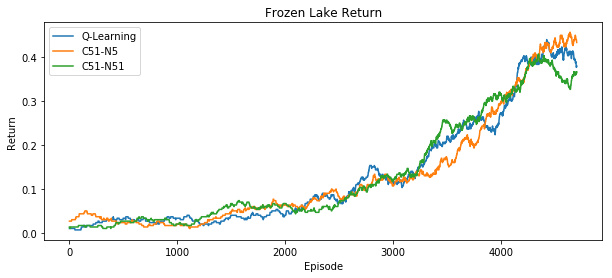

In [141]:
plt.figure(figsize=(10, 4))
plt.title('Frozen Lake Return')
plt.plot(mv(np.load('frozen_lake_q_learning.npy'), 300), label = 'Q-Learning')
plt.plot(mv(np.load('frozen_lake_C51_n5.npy'), 300), label = 'C51-N5')
plt.plot(mv(np.load('frozen_lake_C51_n51.npy'), 300), label = 'C51-N51')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')

Text(0, 0.5, 'Prob')

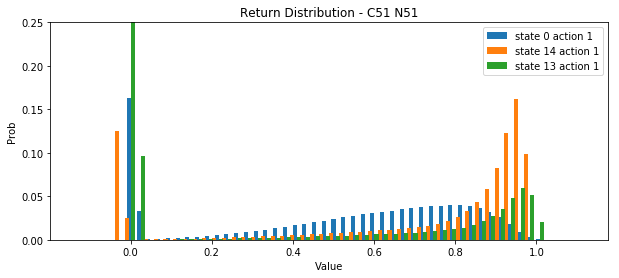

In [142]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution - C51 N51')
plt.bar(c51.z, c51.p[0, 0, :], width = 0.01, label = 'state 0 action 1', linewidth = 5)
plt.bar(c51.z - 0.03, c51.p[14, 0, :], width = 0.01, label = 'state 14 action 1', linewidth = 5)
plt.bar(c51.z + 0.01, c51.p[13, 0, :], width = 0.01, label = 'state 13 action 1', linewidth = 5)
plt.ylim([0, 0.25])
plt.legend()
plt.xlabel('Value')
plt.ylabel('Prob')

## Experiment 2: In toy 10x10 Gridworld

In [213]:
world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)

config = Config(world.nS, world.nA)
config.Vmin = -7; config.Vmax = 1
c51 = C51(config, ifCVaR=True)
q = Qlearning(config)

num_episode = 2500
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.1, 0.9 + ep * ((0 - 0.9)/(num_episode/2)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(world.nA)
        else:
            #a = np.argmax(c51.Q(o))
            a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal = world.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        #q.observe(o, a, r, no, alpha)
        o = no
    returns[ep] = ret

In [214]:
name = 'toy_gridworld_C51_N51_CVaR_alpha025'
np.save(name + '.npy', returns)
np.save(name + '_p.npy', c51.p)
np.save(name + '_z.npy', c51.z)

Text(0, 0.5, 'Return')

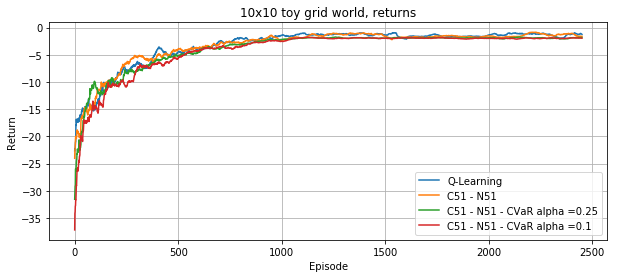

In [215]:
plt.figure(figsize=(10, 4))
plt.title('10x10 toy grid world, returns')
plt.plot(mv(np.load('toy_gridworld_q_learning.npy'), 50), label = 'Q-Learning')
plt.plot(mv(np.load('toy_gridworld_C51_N51.npy'), 50), label = 'C51 - N51')
plt.plot(mv(np.load('toy_gridworld_C51_N51_CVaR_alpha025.npy'), 50), label = 'C51 - N51 - CVaR alpha =0.25')
plt.plot(mv(np.load('toy_gridworld_C51_N51_CVaR_alpha01.npy'), 50), label = 'C51 - N51 - CVaR alpha =0.1')
plt.legend()
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Return')

In [159]:
## Game Play of Q-learning

In [155]:
o = world.reset()
terminal=False
while not terminal:
    #a = np.argmax(c51.CVaR(o, alpha=0.1, N=50))
    a = np.argmax(c51.Q(o))
    no, r, terminal = world.step(a) 
    o = no
    world._render()

##########
#0Xsssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sXssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sXssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssXsssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sssXssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssXsg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sssssXg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssX#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########



In [160]:
## Game Play CVaR = 0.25

In [161]:
o = world.reset()
terminal=False
while not terminal:
    a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
    #a = np.argmax(c51.Q(o))
    no, r, terminal = world.step(a) 
    o = no
    world._render()

##########
#0Xsssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sXssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssXsssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sssXssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sssXssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sssXssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssXsg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sssssXg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssXsg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

#

In [165]:
## Gane Play CVaR = 0.1

In [173]:
o = world.reset()
terminal=False
while not terminal:
    a = np.argmax(c51.CVaR(o, alpha=0.1, N=100))
    #a = np.argmax(c51.Q(o))
    no, r, terminal = world.step(a) 
    o = no
    world._render()

##########
#0ssssssg#
#Xjjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
#Xssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#X ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#X  ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
# X ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
# X      #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#  X     #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#   X    #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#    X   #
#        #
#        #
##########

#

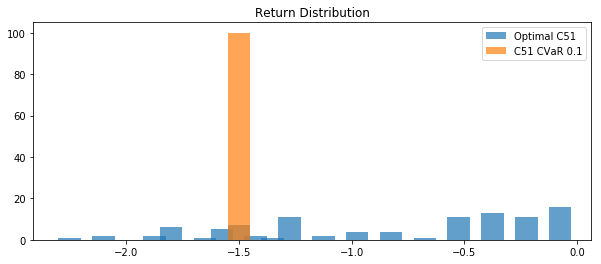

In [219]:
## Distribution
world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)
distributionC51 = distC51(world, np.load('toy_gridworld_C51_N51_p.npy'), config, trial = 100, CVaR =False)
distributionC51_01 = distC51(world, np.load('toy_gridworld_C51_N51_CVaR_alpha01_p.npy'),\
                          config, trial = 100, CVaR =True, alpha=0.1)

plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.hist(distributionC51, bins=30, width=0.1, label='Optimal C51', alpha = 0.7);
plt.hist(distributionC51_01, bins=30, width=0.1, label='C51 CVaR 0.1', alpha = 0.7);
plt.legend()

Text(0, 0.5, 'Prob')

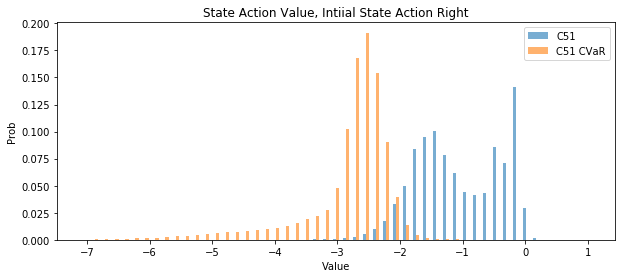

In [227]:
## Action value Distribution
PC51 = np.load('toy_gridworld_C51_N51_p.npy')
z = np.load('toy_gridworld_C51_N51_z.npy')
PC51CVaR01 = np.load('toy_gridworld_C51_N51_CVaR_alpha01_p.npy')
plt.figure(figsize=(10, 4))
plt.title('State Action Value, Intiial State Action Right')
plt.bar(z-0.05, PC51[12, 1, :], width=0.05, label = 'C51', linewidth = 5, alpha=0.6)
plt.bar(z, PC51CVaR01[12, 1, :], width=0.05, label = 'C51 CVaR', linewidth = 5, alpha=0.6)
plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

Text(0, 0.5, 'Prob')

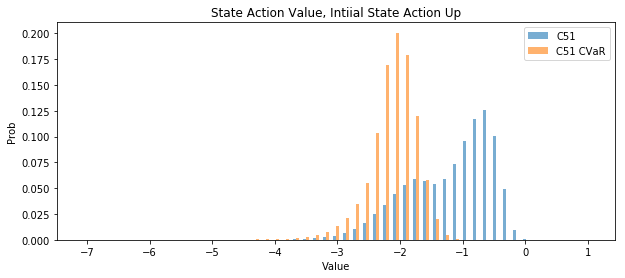

In [225]:
## Action value Distribution
PC51 = np.load('toy_gridworld_C51_N51_p.npy')
z = np.load('toy_gridworld_C51_N51_z.npy')
PC51CVaR01 = np.load('toy_gridworld_C51_N51_CVaR_alpha01_p.npy')
plt.figure(figsize=(10, 4))
plt.title('State Action Value, Intiial State Action Up')
plt.bar(z-0.05, PC51[12, 0, :], width=0.05, label = 'C51', linewidth = 5, alpha=0.6)
plt.bar(z, PC51CVaR01[12, 0, :], width=0.05, label = 'C51 CVaR', linewidth = 5, alpha=0.6)
plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

Text(0.5,0,'return')

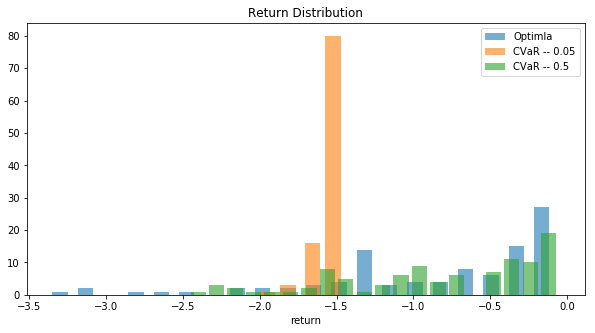

In [68]:
plt.figure(figsize=(10,5))
plt.hist(distribution, bins=20, width=0.1, label = 'Optimla', alpha = 0.6);
plt.hist(distributionCVaR, bins=20, width=0.1, label = 'CVaR -- 0.05', alpha = 0.6);
plt.hist(distributionCVaR2, bins=20, width=0.1, label = 'CVaR -- 0.5', alpha = 0.6);
plt.legend()
plt.title('Return Distribution')
plt.xlabel('return')

## Experiment 3, Fast Learning -- With Optimistic Initialization

In [11]:
## optimisitc initialization without and wit bootstrapping

In [241]:
world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)
b_num = 5 # No bootstrap
config = Config(world.nS, world.nA)
config.Vmin = -7; config.Vmax = 1
c51 = []
for b in range(b_num):
    c51.append(C51(config, init = 'optimistic', ifCVaR = True))

num_episode = 2500
returns = np.zeros(num_episode)
CVaRs = np.zeros((num_episode, world.nA))
for ep in range(num_episode):
    terminal = False
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    o_init = o
    ret = 0
    while not terminal:
        Qlist = np.array([x.CVaR(o, alpha=0.1, N=50) for x in c51])
        best = np.max(Qlist, axis = 0)
        a = np.argmax(best)
        network = np.argmax(Qlist[:, a])
        no, r, terminal = world.step(a) 
        ret += r
        c51[network].observe(o, a, r, no, terminal, alpha)
        o = no
    returns[ep] = ret
    CVaRs[ep, :] = c51[0].CVaR(o_init, alpha=0.05, N=100)

In [242]:
# name = 'toy_gridworld_C51_N51_CVaR_alpha01_optimistic_bootstrap_5'
# np.save(name + '.npy', returns)
# np.save(name + '_p.npy', c51[0].p)
# np.save(name + '_z.npy', c51[0].z)
# np.save(name + '_CVaRs.npy', CVaRs)

Text(0, 0.5, 'Return')

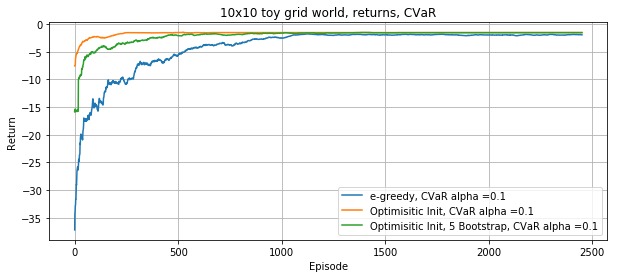

In [243]:
plt.figure(figsize=(10, 4))
plt.title('10x10 toy grid world, returns, CVaR')
plt.plot(mv(np.load('toy_gridworld_C51_N51_CVaR_alpha01.npy'), 50), label = 'e-greedy, CVaR alpha =0.1')
plt.plot(mv(np.load('toy_gridworld_C51_N51_CVaR_alpha01_optimistic.npy'), 50), label = 'Optimisitic Init, CVaR alpha =0.1')
plt.plot(mv(np.load('toy_gridworld_C51_N51_CVaR_alpha01_optimistic_bootstrap_5.npy'), 50), label = 'Optimisitic Init, 5 Bootstrap, CVaR alpha =0.1')

plt.legend()
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Return')

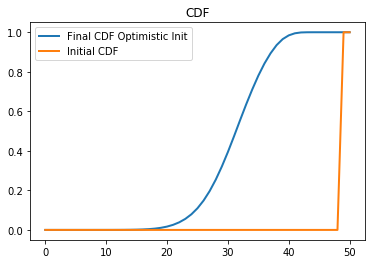

In [67]:
P = np.load('toy_gridworld_C51_N51_CVaR_alpha01_optimistic_p.npy')
Pinit = np.zeros((config.nS, config.nA, config.nAtoms))
Pinit[:, :, -2] = 1
plt.plot(np.cumsum(P[12, 0, :]), linewidth = 2, label = 'Final CDF Optimistic Init')
plt.plot(np.cumsum(Pinit[12, 0, :]), linewidth = 2, label = 'Initial CDF')
plt.title('CDF')
plt.legend()

## Experiment 4, Bootstrapping With Random Initialization

same results holds with infinite replay buffer, and more and less bootstrapping

In [12]:
## Bootstrapping

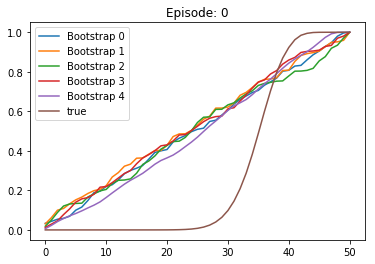

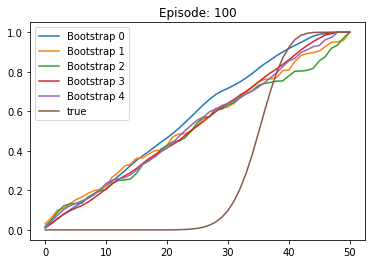

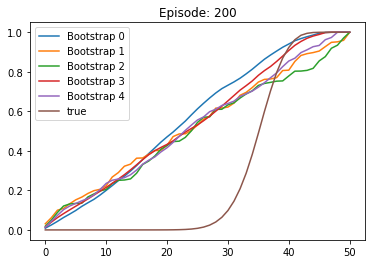

In [13]:
world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)
b_num = 5 # No bootstrap
config = Config(world.nS, world.nA)
config.Vmin = -7; config.Vmax = 1
c51 = []
for b in range(b_num):
    c51.append(C51(config, init = 'random', ifCVaR = True))

num_episode = 300
max_step = 300
returns = np.zeros(num_episode)
CVaRs = np.zeros((num_episode, world.nA))
for ep in range(num_episode):
    terminal = False
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    o_init = o
    ret = 0
    step = 0
    while not terminal and step < max_step:
        Qlist = np.array([x.CVaR(o, alpha=0.1, N=50) for x in c51])
        best = np.max(Qlist, axis = 0)
        a = np.argmax(best)
        network = np.argmax(Qlist[:, a])
        no, r, terminal = world.step(a) 
        ret += r
        c51[network].observe(o, a, r, no, terminal, alpha)
        o = no
        step += 1
    if ep%100 == 0:
        plt.figure()
        for i in range(b_num):
            plt.plot(np.cumsum(c51[i].p[12, 0, :]), label = 'Bootstrap %d'%(i))
        plt.plot(np.load('optimistic_cdf.npy'), label='true')
        plt.title('Episode: %d'%(ep))
        plt.legend()
        plt.show()
    returns[ep] = ret
    CVaRs[ep, :] = c51[0].CVaR(o_init, alpha=0.05, N=100)

In [14]:
name = 'toy_gridworld_C51_N51_CVaR_alpha01_random_bootstrap_5'
np.save(name + '.npy', returns)
np.save(name + '_p.npy', c51[0].p)
np.save(name + '_z.npy', c51[0].z)
np.save(name + '_CVaRs.npy', CVaRs)

Text(0,0.5,'Return')

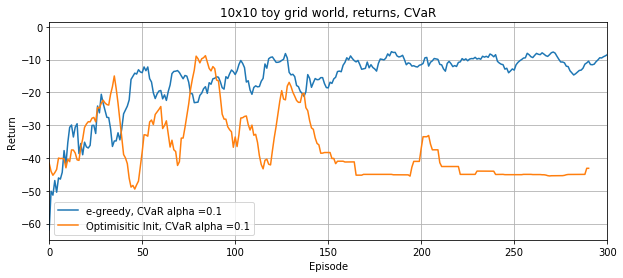

In [15]:
plt.figure(figsize=(10, 4))
plt.title('10x10 toy grid world, returns, CVaR')
plt.plot(mv(np.load('toy_gridworld_C51_N51_CVaR_alpha01.npy'), 10), label = 'e-greedy, CVaR alpha =0.1')
plt.plot(mv(np.load('toy_gridworld_C51_N51_CVaR_alpha01_random_bootstrap_5.npy'), 10), label = 'Optimisitic Init, CVaR alpha =0.1')
plt.xlim([0, 300])
plt.legend()
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Return')

To add here: Using temprature to solve the issue, it is not quite working, but it's a good observation.

## Experiment 5: Optimism Bonus and Machine Repair

e-greedy performance

In [11]:
from mrp import machine_repair

In [ ]:
world = machine_repair()

config = Config(world.nS, world.nA)
config.Vmin = -30; config.Vmax = 30
c51 = C51(config, init = 'random', ifCVaR = False)
counts = np.zeros((world.nS, world.nA)) + 1

const = 20
num_episode = 2000
trial = 100
returns = np.zeros((num_episode, trial))
returns_online = np.zeros((num_episode, trial))

#CVaRs = np.zeros((num_episode, world.nA))
for ep in range(num_episode):
    terminal = False
    e = max(0.1, 0.9 + ep * ((0 - 0.9)/(num_episode/2)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    o_init = o
    ret = 0
    while not terminal:
        if np.random.rand() <= e:
            a = np.random.randint(world.nA)
        else:
            a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
        no, r, terminal = world.step(a) 
        counts[o, a] += 1
        ret += r
        c51.observe(o, a, r , no, terminal, alpha)
        o = no
    # Greedy Policy Performance
    tot_rep = np.zeros(trial)
    for ep_t in range(trial):
        terminal = False
        o = world.reset()
        o_init = o
        ret = 0
        while not terminal:
            a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            no, r, terminal = world.step(a) 
            ret += r
            o = no
        tot_rep[ep_t] = ret
    returns[ep, :] = tot_rep

    # Online Policy Performance
    tot_rep = np.zeros(trial)
    for ep_t in range(trial):
        terminal = False
        o = world.reset()
        o_init = o
        ret = 0
        while not terminal:
            if np.random.rand() <= e:
                a = np.random.randint(world.nA)
            else:
                a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            no, r, terminal = world.step(a) 
            ret += r
            o = no
        tot_rep[ep_t] = ret
    returns_online[ep, :] = tot_rep
    if ep%100 == 0:
        print('episode: %d'%(ep))
np.save('e_greedy_online_0.npy', returns_online)
np.save('e_greedy_eval_0.npy', returns)

count based performance

In [17]:
world = machine_repair()

config = Config(world.nS, world.nA)
config.Vmin = -30; config.Vmax = 30
c51 = C51(config, init = 'random', ifCVaR = True)
counts = np.zeros((world.nS, world.nA)) + 1

const = 20
num_episode = 2000
trial = 100
returns = np.zeros((num_episode, trial))
returns_online = np.zeros((num_episode, trial))

CVaRs = np.zeros((num_episode, world.nA))
for ep in range(num_episode):
    terminal = False
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    o_init = o
    ret = 0
    while not terminal:
        a = np.argmax(c51.CVaR(o, alpha=0.5, N=50) + const/np.sqrt(counts[o, :]))
        no, r, terminal = world.step(a) 
        counts[o, a] += 1
        ret += r
        c51.observe(o, a, r + const/np.sqrt(counts[o, a]), no, terminal, alpha)
        o = no
    
    tot_rep = np.zeros(trial)
    for ep_t in range(trial):
        terminal = False
        o = world.reset()
        o_init = o
        ret = 0
        while not terminal:
            a = np.argmax(c51.CVaR(o, alpha=0.5, N=50))
            no, r, terminal = world.step(a) 
            ret += r
            o = no
        tot_rep[ep_t] = ret
    returns[ep, :] = tot_rep
    
    tot_rep = np.zeros(trial)
    for ep_t in range(trial):
        terminal = False
        o = world.reset()
        o_init = o
        ret = 0
        while not terminal:
            a = np.argmax(c51.CVaR(o, alpha=0.5, N=50) + const/np.sqrt(counts[o, :]))
            no, r, terminal = world.step(a) 
            ret += r
            o = no
        tot_rep[ep_t] = ret
    returns_online[ep, :] = tot_rep
    if ep%100 == 0:
        print('episode: %d'%(ep))
np.save('count_based_online_0.npy', returns_online)
np.save('count_based_eval_0.npy', returns)

KeyboardInterrupt: 

## Experiment 5: Optimistic Initialization with Machine Repair

In [11]:
from mrp import machine_repair

In [15]:
optimal_policy = np.ones(10)
optimal_policy[-2] = 0

In [368]:
world = machine_repair()

config = Config(world.nS, world.nA)
config.Vmin = -30; config.Vmax = 30
c51 = C51(config, init = 'random', ifCVaR = True)
counts = np.zeros((world.nS, world.nA)) + 1

const = 20
num_episode = 250
returns = np.zeros((num_episode, 100))
CVaRs = np.zeros((num_episode, world.nA))
for ep in range(num_episode):
    terminal = False
    e = max(0.05, 0.9 + ep * ((0 - 0.9)/(num_episode/2)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    o_init = o
    ret = 0
    while not terminal:
        #a = int(optimal_policy[o])
        if np.random.rand() <= e:# and False:
            a = np.random.randint(world.nA)
        else:
            #a = np.argmax(c51.Q(o) + const/np.sqrt(counts[o, :]))
            #a = np.argmax(c51.Q(o) + 0.2/np.sqrt(counts[o, :]))
            a = np.argmax(c51.CVaR(o, alpha=0.5, N=50))# + const/np.sqrt(counts[o, :]))# - 20/np.sqrt(counts[o, :]))
            #print(c51.CVaR(o, alpha=0.5, N=50), const/np.sqrt(counts[o, :]))
        no, r, terminal = world.step(a) 
        counts[o, a] += 1
        ret += r
        c51.observe(o, a, r  , no, terminal, alpha)
        o = no
    test_num = 100
    
    tot_rep = np.zeros(100)
    for ep_t in range(test_num):
        terminal = False
        o = world.reset()
        o_init = o
        ret = 0
        while not terminal:
            if np.random.rand() <= e:# and False:
                a = np.random.randint(world.nA)
            else:
                a = np.argmax(c51.CVaR(o, alpha=0.5, N=50))# + const/np.sqrt(counts[o, :]))
            no, r, terminal = world.step(a) 
            ret += r
            o = no
        tot_rep[ep_t] = ret
    #print(ep, tot_rep/20)
    returns[ep, :] = tot_rep

In [369]:
np.save('e_greedy_online.npy', returns)

In [34]:
CVaR = np.zeros((4, 2000))
for jj in range(4):
    returns = np.load('e_greedy_eval_%d.npy'%(jj))
    for i in range(2000):
        var = np.sort(returns[i, :])[int(len(returns[i ,:])/100 * 25)]
        idx = np.where(returns[i, :] <= var)
        CVaR[jj, i] = np.mean(returns[i, idx])

In [29]:
count_based_online = CVaR[0, :]

In [35]:
e_greedy_eval = np.mean(CVaR, axis=0)

Text(0.5,0,'Episode')

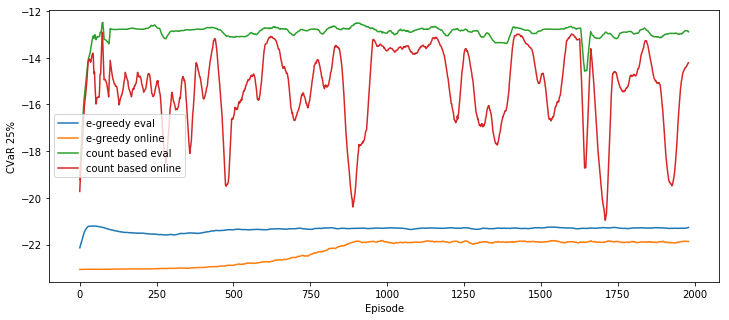

In [42]:
plt.figure(figsize=(12, 5))
plt.plot(mv(e_greedy_eval, 20), label='e-greedy eval')
plt.plot(mv(e_greedy_online, 20), label='e-greedy online')
plt.plot(mv(count_based_eval, 20), label='count based eval')
plt.plot(mv(count_based_online, 20), label='count based online')
plt.legend()
plt.ylabel('CVaR 25%')
plt.xlabel('Episode')

In [371]:
np.save('e_greedy_online_CVaR.npy', CVaR)

In [12]:
e_greedy = np.load('e_greedy_online_0.npy')

Text(0, 0.5, 'CVaR 25% quantile')

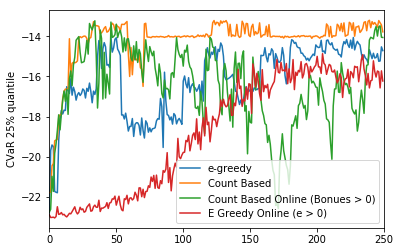

In [372]:
plt.plot(mv(np.load('e_greedy_CVaR.npy'), 1), label = 'e-greedy')
plt.plot(mv(np.load('count_based_CVaR.npy'), 1), label = 'Count Based')
plt.plot(mv(np.load('count_based_online_CVaR.npy'), 1), label = 'Count Based Online (Bonues > 0)')
plt.plot(mv(np.load('e_greedy_online_CVaR.npy'), 1), label = 'E Greedy Online (e > 0)')
plt.legend()
plt.xlim([0, 250])
plt.ylabel('CVaR 25% quantile')

In [275]:
np.save('count_test.npy', returns)

In [266]:
np.save('q_test.npy', returns)

(0, 200)

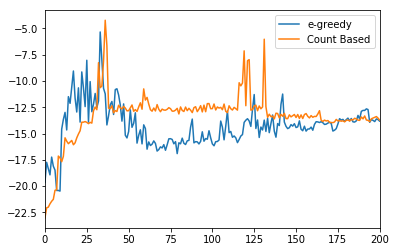

In [276]:

plt.plot(mv(np.load('q_test.npy'), 1), label = 'e-greedy')
plt.plot(mv(np.load('count_test.npy'), 1), label = 'Count Based')
#plt.plot(-12.58397378015751 * np.ones(250), label = 'Optimal CVaR')
plt.legend()
plt.xlim([0, 200])

In [205]:
num_episode = 5000
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    o = world.reset()
    o_init = o
    ret = 0
    while not terminal:
        a = np.argmax(c51.Q(o))
        no, r, terminal = world.step(a) 
        ret += r
        o = no
    returns[ep] = ret

In [311]:
for i in range(10):
    print(c51.CVaR(i, alpha=0.5, N=50))

[-23.376 -15.912]
[-21.792 -15.696]
[-20.52  -16.368]
[-19.2   -16.704]
[-18.  -16.8]
[-16.8   -15.792]
[-15.6   -16.776]
[-15.888 -17.904]
[-13.92 -20.64]
[-15.408 -13.92 ]


<BarContainer object of 51 artists>

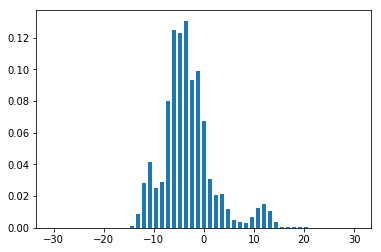

In [360]:
plt.bar(c51.z, c51.p[0, 1, :])

In [202]:
print(np.mean(returns))
for i in range(10):
    print(c51.CVaR(i, alpha=0.5, N=50))

-15.073177692778664
[-19.08  -12.432]
[-18.144 -12.84 ]
[-18.    -12.744]
[-17.448 -12.528]
[-16.8   -13.224]
[-16.272 -14.016]
[-15.072 -13.896]
[-13.896 -14.496]
[-12.6   -21.576]
[-14.712 -14.52 ]


In [203]:
name = 'c51_mrp_N10_CVaR_count'
np.save(name + '.npy', returns)
np.save(name + '_p.npy', c51.p)
np.save(name + '_z.npy', c51.z)

Text(0, 0.5, 'Return')

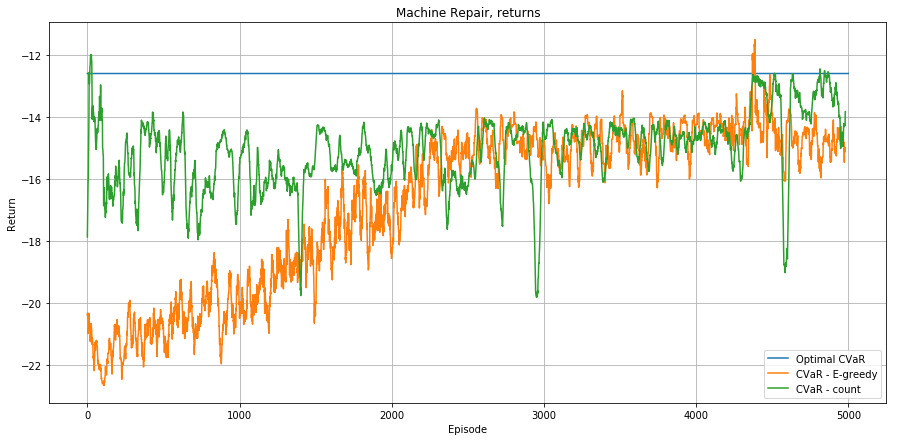

In [251]:
plt.figure(figsize=(15, 7))
plt.title('Machine Repair, returns')
plt.plot(-12.58397378015751 * np.ones(5000), label = 'Optimal CVaR')
#plt.plot(-7.980802416187743 * np.ones(5000), label = 'Optimal')
#plt.plot(mv(np.load('mrp_C51_N51.npy'), 100), label = 'C51')
#plt.plot(mv(np.load('c51_mrp_N10_e_greedy_Q.npy'), 150), label = 'Expected - e-greedy')
#plt.plot(mv(np.load('c51_mrp_N10_countbased_Q.npy'), 150), label = 'Expected - count based')
plt.plot(mv(np.load('c51_mrp_N10_CVaR_e_greedy.npy'), 20), label = 'CVaR - E-greedy')
plt.plot(mv(np.load('c51_mrp_N10_CVaR_count.npy'), 20), label = 'CVaR - count')
#plt.plot(returns[0:80])
plt.legend()
plt.grid()
plt.xlabel('Episode')
plt.ylabel('Return')
#plt.xlim([0, 80])

(-25, 0)

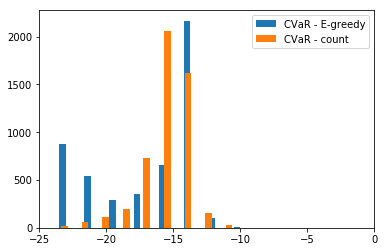

In [214]:
#plt.hist(np.load('c51_mrp_N10_e_greedy_Q.npy'), bins=20, width = 0.5, label = 'Expected - e-greedy');
plt.hist(np.load('c51_mrp_N10_CVaR_e_greedy.npy'), bins=20, width = 0.5, label = 'CVaR - E-greedy');
plt.hist(np.load('c51_mrp_N10_CVaR_count.npy'), bins=20, width = 0.5, label = 'CVaR - count');
plt.legend()
plt.xlim([-25, 0])

In [208]:
distributionC51 = distC51(world, np.load('c51_mrp_N10_e_greedy_Q_p.npy'), config, trial = 100, CVaR =False)
distributionC51CVaR = distC51(world, np.load('c51_mrp_N10_CVaR_e_greedy_p.npy'), config, trial = 200, CVaR =True)
distributionC51CVaRCount = distC51(world, np.load('c51_mrp_N10_CVaR_count_p.npy'), config, trial = 200, CVaR =True)

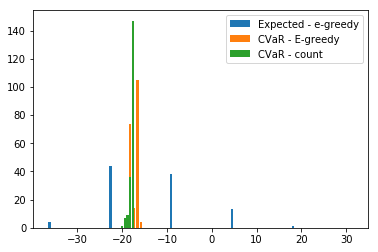

In [209]:
plt.hist(distributionC51, bins=5, width = 0.5, label = 'Expected - e-greedy');
plt.hist(distributionC51CVaR, bins=5, width = 0.5, label = 'CVaR - E-greedy');
plt.hist(distributionC51CVaRCount, bins=5, width = 0.5, label = 'CVaR - count');
plt.legend()
#plt.xlim([-25, 0])

Seems like count based is not helping with CVaR optmization, but optimisitc CVaR is. **Why**

## Machine Repair -- Original

In [11]:
from mrp_normal import machine_repair

In [12]:
optimal_policy = np.ones(10)
optimal_policy[-2] = 0

In [13]:
world = machine_repair()
config = Config(world.nS, world.nA)
config.Vmin = -10; config.Vmax = 10
c51 = C51(config, init = 'random', ifCVaR = False)
counts = np.zeros((world.nS, world.nA)) + 1
gamma = 0.8

num_episode = 50000
returns = np.zeros(num_episode)
CVaRs = np.zeros((num_episode, world.nA))
for ep in range(num_episode):
    terminal = False
    e = max(0.01, 0.9 + ep * ((0 - 0.9)/(num_episode/2)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    o_init = o
    ret = 0
    step = 0
    while not terminal:
        a = int(optimal_policy[o])
#         if np.random.rand() <= e and False:
#             a = np.random.randint(world.nA)
#         else:
#             #a = np.argmax(c51.Q(o))
#             a = np.argmax(c51.Q(o) + 10/np.sqrt(counts[o, :]))
#             #a = np.argmax(c51.CVaR(o, alpha=0.5, N=50))# - 20/np.sqrt(counts[o, :]))
        no, r, terminal = world.step(a) 
        counts[o, a] += 1
        ret += gamma**step * r
        step += 1
        c51.observe(o, a, r/100, no, terminal, alpha)
        o = no
    returns[ep] = ret

KeyboardInterrupt: 

In [168]:
name = 'mrp_normal_egreedy_count_based'
np.save(name + '.npy', returns)
np.save(name + '_p.npy', c51.p)
np.save(name + '_z.npy', c51.z)

##### Check the Distributions

In [84]:
notRepair = np.load('normal_not_repair.npy')
lastRepair = np.load('normal_last_repair.npy')
oneLastRepair = np.load('normal_one_before_last_reapir.npy')

not repair -1.5507087034375422 last repair -2.0317372324818312 one before last repair -4.06218568877488
not repair 12.55833599288814 last repair 0.31200790271895207 one before last repair 0.031176224486681434


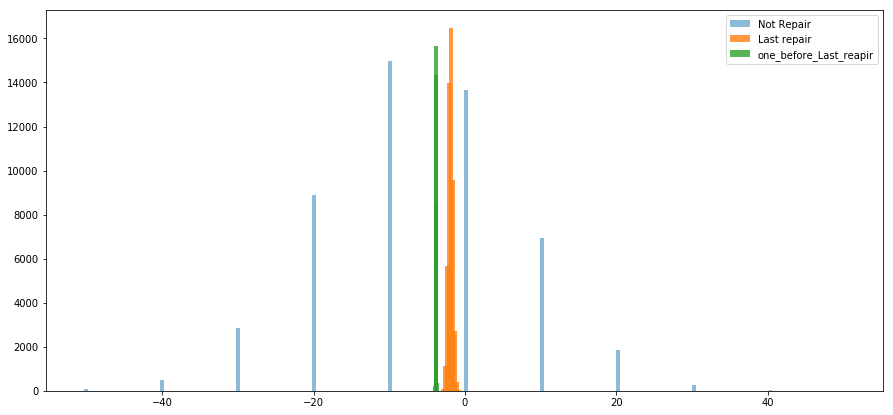

In [92]:
plt.figure(figsize=(15, 7))
plt.hist(notRepair,  width=0.5, alpha = 0.5, label = 'Not Repair');
plt.hist(lastRepair, alpha = 0.8,  width=0.5, label = 'Last repair');
plt.hist(oneLastRepair, alpha = 0.8,  width=0.5, label = 'one_before_Last_reapir');
plt.legend()
print('not repair', np.mean(notRepair), 'last repair', np.mean(lastRepair), 'one before last repair', np.mean(oneLastRepair))

print('not repair', np.std(notRepair), 'last repair', np.std(lastRepair), 'one before last repair', np.std(oneLastRepair))

#### Learning

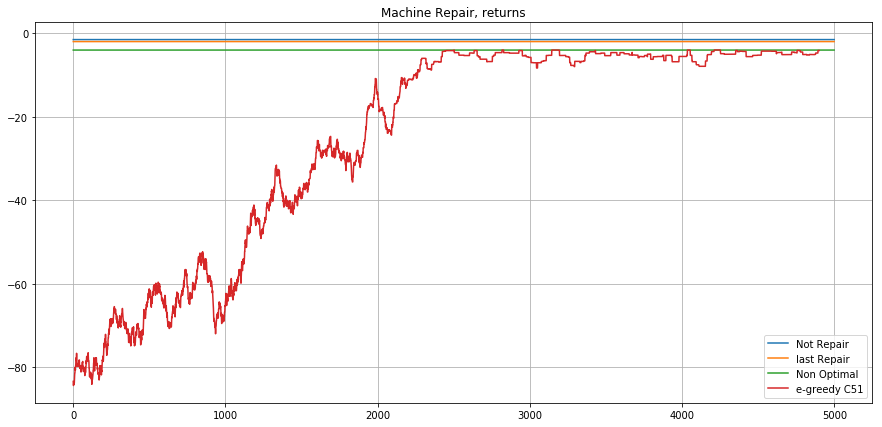

In [173]:
plt.figure(figsize=(15, 7))
plt.title('Machine Repair, returns')
plt.plot(-1.5507087034375422 * np.ones(5000), label = 'Not Repair')
plt.plot(-2.0317372324818312 * np.ones(5000), label = 'last Repair')
plt.plot(-4.06218568877488 * np.ones(5000), label = 'Non Optimal')

plt.plot(mv(np.load('mrp_normal_egreedy.npy'), 100), label = 'e-greedy C51')
#plt.plot(mv(np.load('mrp_normal_egreedy_count_based.npy'), 300), label = 'count based C51')
#plt.ylim([-20, 0])
plt.grid()
plt.legend()

In [159]:
for i in range(8):
    print(c51.Q(i))

[-1.29882195 -1.24969   ]
[-1.30877361 -1.26286605]
[-1.31424975 -1.27585831]
[-1.30019784 -1.28879491]
[-1.30495372 -1.30217573]
[-1.3161343  -1.32510974]
[-1.22526326 -2.27349652]
[-0.07358095 -0.36521131]


## Trash

Text(0, 0.5, 'Prob')

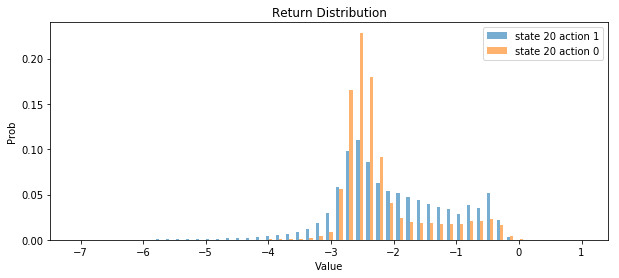

In [95]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
#plt.bar(c51.z, c51.p[12, 2, :], width=0.01, label = 'state 20 action 2', linewidth = 5, alpha=0.6)
plt.bar(c51.z-0.05, c51.p[12, 1, :], width=0.05, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[12, 0, :], width=0.05, label = 'state 20 action 0', linewidth = 5, alpha=0.6)
plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

In [97]:
distribution = dist(world, c51, CVaR=True)
plt.hist(distribution, bins=30, width=0.1);

KeyboardInterrupt: 

In [26]:
## Now CVaR -- 0.1

In [66]:
world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)

config = Config(world.nS, world.nA)
config.Vmin = -7; config.Vmax = 1
c51 = C51(config)
q = Qlearning(config)

num_episode = 5000
returns = np.zeros(num_episode)
CVaRs = np.zeros((num_episode, world.nA))
for ep in range(num_episode):
    terminal = False
    e = max(0.1, 0.9 + ep * ((0 - 0.9)/(num_episode/2)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    o_init = o
    CVaRs[ep, :] = c51.CVaR(o_init, alpha=0.05, N=100)
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(world.nA)
        else:
            #a = np.argmax(c51.Q(o))
            a = np.argmax(c51.CVaR(o, alpha=0.05, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal = world.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        q.observe(o, a, r, no, alpha)
        o = no
    returns[ep] = ret

In [67]:
np.save('C51returns_compare.npy', returns)

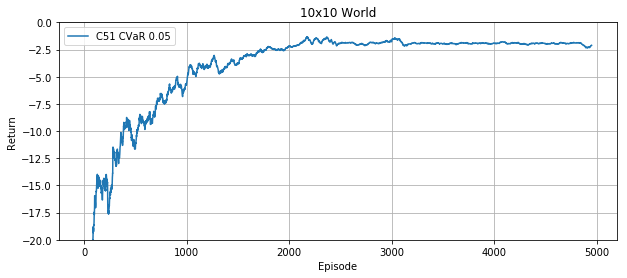

In [68]:
plt.figure(figsize=(10, 4))
plt.title('10x10 World')
plt.plot(mv(returns, 50), label = 'C51 CVaR 0.05')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid()
plt.ylim([-20, 0]);

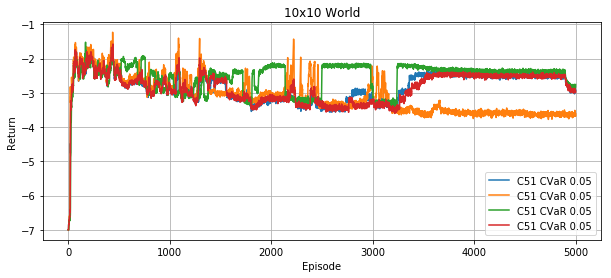

In [69]:
plt.figure(figsize=(10, 4))
plt.title('10x10 World')
plt.plot(mv(CVaRs[:, 0], 1), label = 'C51 CVaR 0.05')
plt.plot(mv(CVaRs[:, 1], 1), label = 'C51 CVaR 0.05')
plt.plot(mv(CVaRs[:, 2], 1), label = 'C51 CVaR 0.05')
plt.plot(mv(CVaRs[:, 3], 1), label = 'C51 CVaR 0.05')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid()
#plt.ylim([-20, 0]);
#plt.xlim([0, 500])

In [70]:
np.save('C51CVaRs.npy', CVaRs)

In [73]:
# np.save('C51CVaR05return.npy', returns)
# np.save('C51CVaR05p.npy', c51.p)

Text(0,0.5,'Prob')

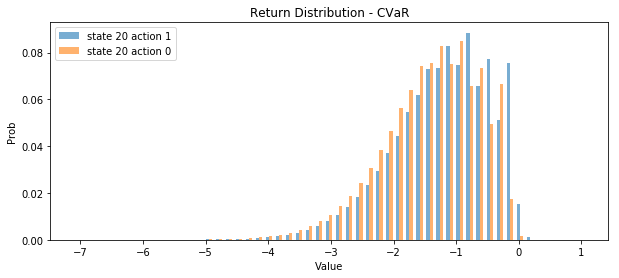

In [58]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution - CVaR')
#plt.bar(c51.z, c51.p[12, 2, :], width=0.01, label = 'state 20 action 2', linewidth = 5, alpha=0.6)
plt.bar(c51.z-0.05, c51.p[12, 1, :], width=0.05, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[12, 0, :], width=0.05, label = 'state 20 action 0', linewidth = 5, alpha=0.6)
plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

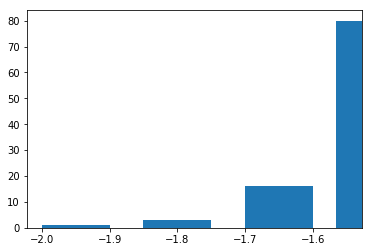

In [59]:
distributionCVaR = dist(world, c51, CVaR=True, alpha=0.05)
plt.hist(distributionCVaR, bins=30, width=0.1);

In [50]:
o = world.reset()
terminal=False
while not terminal:
    a = np.argmax(c51.CVaR(o, alpha=0.1, N=50))
    no, r, terminal = world.step(a) 
    o = no
    world._render()

##########
#0ssssssg#
#Xjjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
#Xssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#X ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#X  ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#X       #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
# X      #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#  X     #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#   X    #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#    X   #
#        #
#        #
##########

#

In [32]:
# Now CVaR 0.25

In [39]:
world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)

config = Config(world.nS, world.nA)
config.Vmin = -7; config.Vmax = 1
c51 = C51(config)
q = Qlearning(config)

num_episode = 2000
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.1, 0.9 + ep * ((0 - 0.9)/(num_episode/2)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(world.nA)
        else:
            #a = np.argmax(c51.Q(o))
            a = np.argmax(c51.CVaR(o, alpha=0.5, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal = world.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        q.observe(o, a, r, no, alpha)
        o = no
    returns[ep] = ret

Text(0,0.5,'Prob')

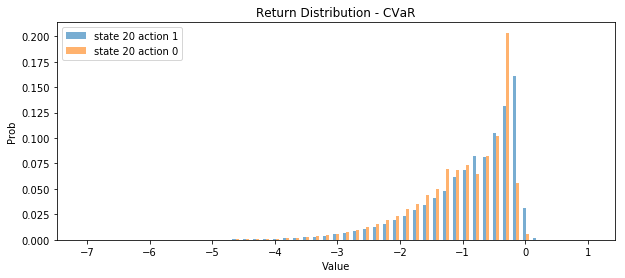

In [40]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution - CVaR')
#plt.bar(c51.z, c51.p[12, 2, :], width=0.01, label = 'state 20 action 2', linewidth = 5, alpha=0.6)
plt.bar(c51.z-0.05, c51.p[12, 1, :], width=0.05, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[12, 0, :], width=0.05, label = 'state 20 action 0', linewidth = 5, alpha=0.6)
plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

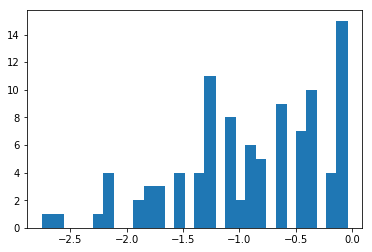

In [46]:
distributionCVaR2 = dist(world, c51, CVaR=True, alpha=0.5)
plt.hist(distributionCVaR2, bins=30, width=0.1);

In [43]:
o = world.reset()
terminal=False
while not terminal:
    a = np.argmax(c51.CVaR(o, alpha=0.5, N=50))
    no, r, terminal = world.step(a) 
    o = no
    world._render()

##########
#0Xsssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sXssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0Xsssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sXssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssXsssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0sssXssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjXjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjXj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjX #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

#

### How fast we learn this policy?

In [ ]:
# Random Initialization

In [81]:
def softmax(x, temp = 10):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

In [82]:
class C51Temp():
    def __init__(self, config, init='uniform', ifCVaR = False, temp=10):
        self.ifCVaR = ifCVaR
        self.config = config
        self.temp = temp

        self.theta = np.random.rand(self.config.nS, self.config.nA,\
                    self.config.nAtoms)
        
        self.dz = (self.config.Vmax - self.config.Vmin)/(self.config.nAtoms-1)
        self.z = np.arange(self.config.nAtoms) * self.dz + self.config.Vmin
    def p(self, x, a):
        return self.softmax(self.theta[x, a, :], self.temp)
    
    def observe(self, x, a, r, nx, terminal, alpha):
        if not self.ifCVaR: #Normal
            Q_nx = np.zeros(self.config.nA)
            for at in range(self.config.nA):
                Q_nx[at] = np.sum([self.p(x, at, i) for i in range(self.config.nAtoms)] * self.z)
            a_star = np.argmax(Q_nx)
        else:
            Q_nx = self.CVaR(x, alpha, N=20)
            a_star = np.argmax(Q_nx)

        m = np.zeros(self.config.nAtoms)
        for i in range(self.config.nAtoms):
            if not terminal:
                tz = np.clip(r + self.config.gamma*self.z[i],\
                        self.config.Vmin, self.config.Vmax)
            else:
                tz = np.clip(r,\
                        self.config.Vmin, self.config.Vmax)
            b = (tz - self.config.Vmin)/self.dz
            l = int(np.floor(b)); u = int(np.ceil(b))
            m[l] += self.p(nx, a_star)[i] * (u-b)
            m[u] += self.p(nx, a_star)[i] * (b-l)
            
        self.theta[x, a, :] = self.theta[x, a, :] + alpha/self.temp *\
            (m - np.sum(m * self.p(x,a)))

    def Q(self, x):
        Q_nx = np.zeros(self.config.nA)
        for at in range(self.config.nA):
            Q_nx[at] = np.sum(self.p(x, at) * self.z)
        return Q_nx

    def CVaR(self, x, alpha, N=20):
        Q = np.zeros(self.config.nA)
        for a in range(self.config.nA):
            values = np.zeros(N)
            for n in range(N):
                tau = np.random.uniform(0, alpha)
                idx = np.argmax(np.cumsum(self.p(x, a) > tau) * 1.0)
                z = self.z[idx]
                values[n] = z
            Q[a] = np.mean(values)
        return Q
    def softmax(self, x, temp):
        e_x = np.exp((x - np.max(x))/temp)
        return e_x / e_x.sum()

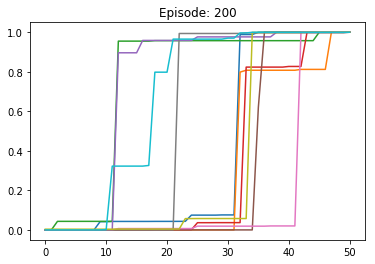

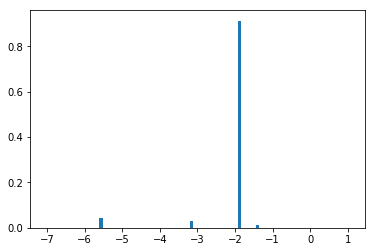

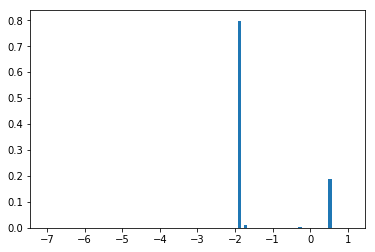

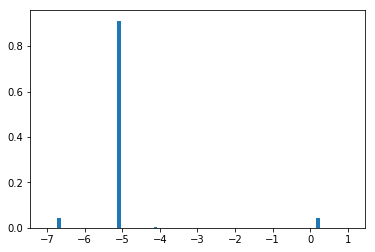

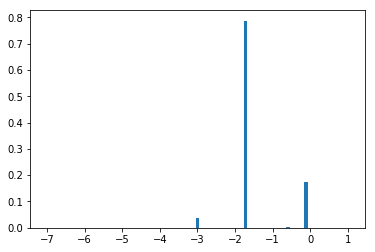

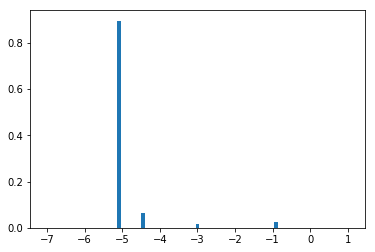

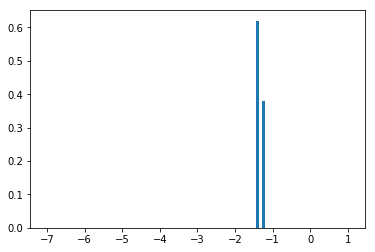

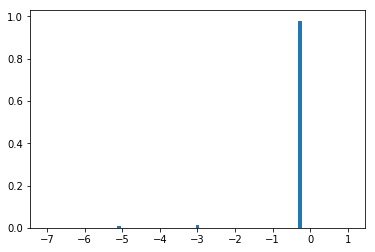

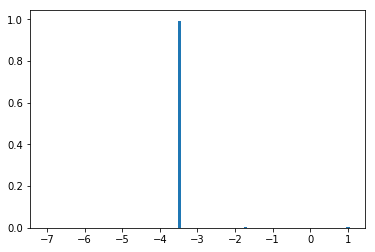

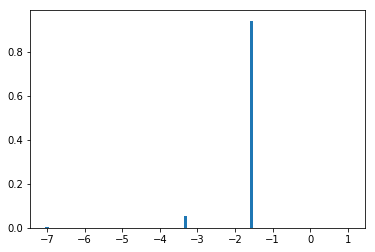

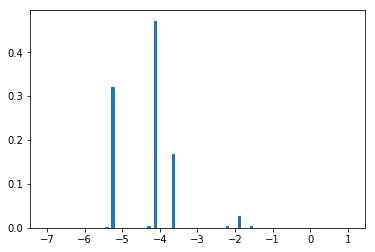

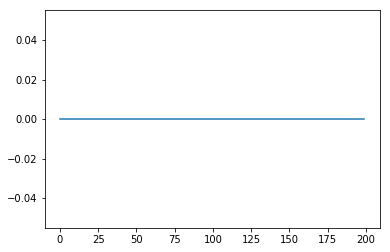

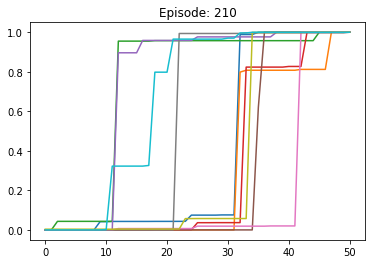

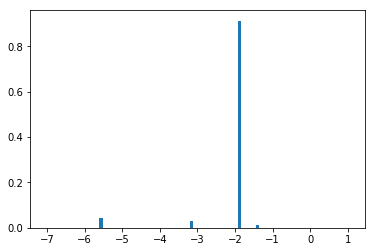

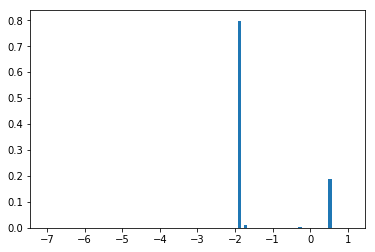

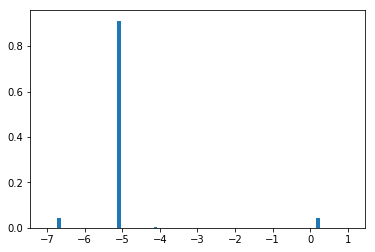

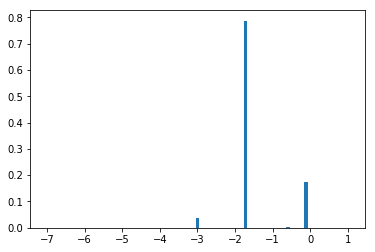

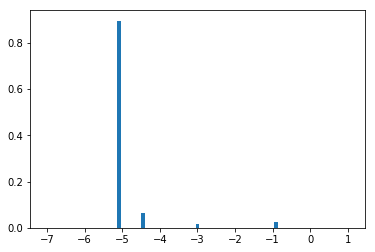

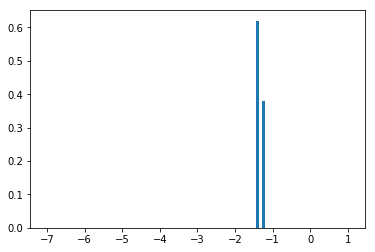

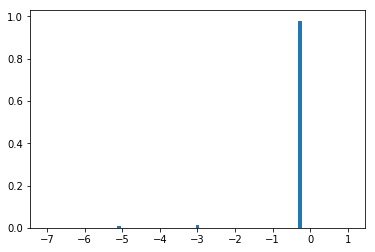

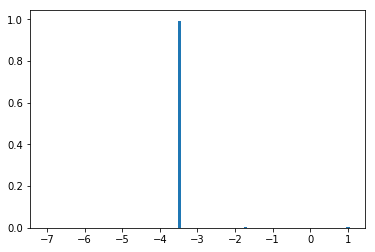

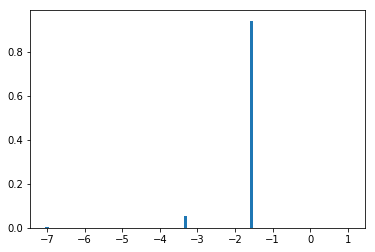

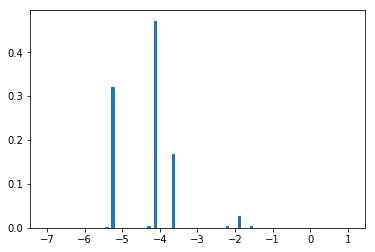

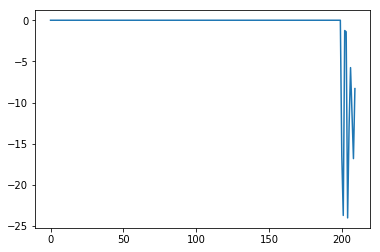

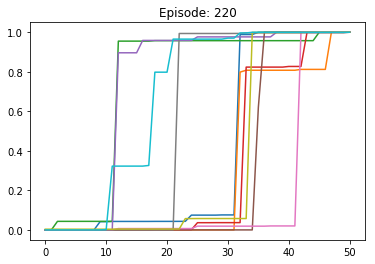

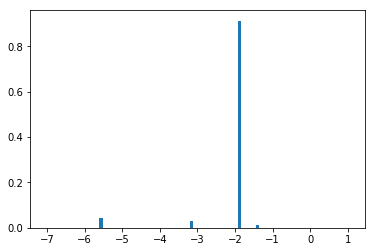

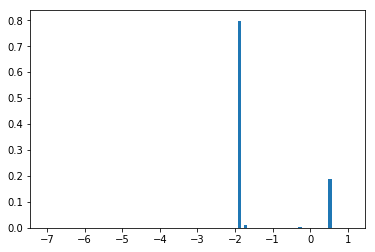

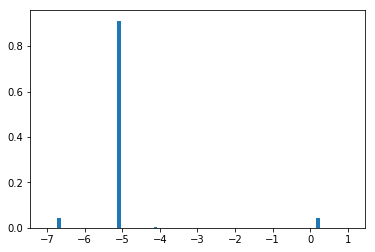

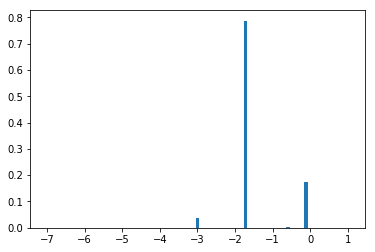

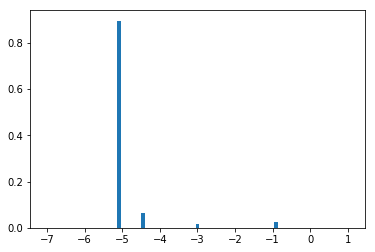

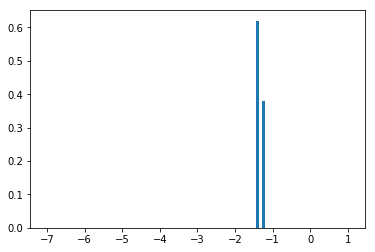

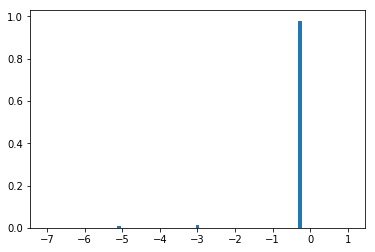

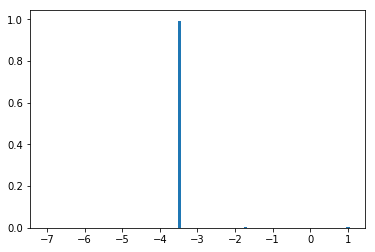

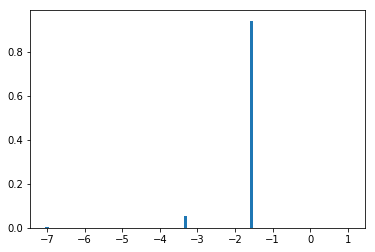

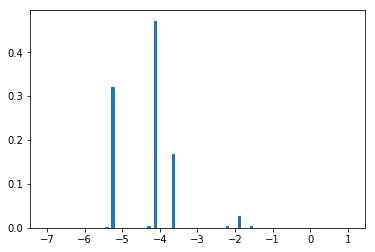

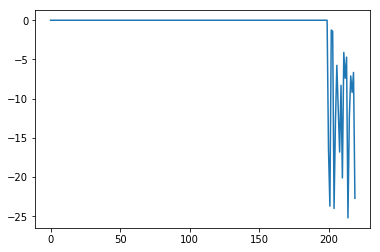

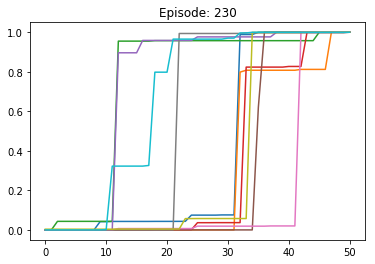

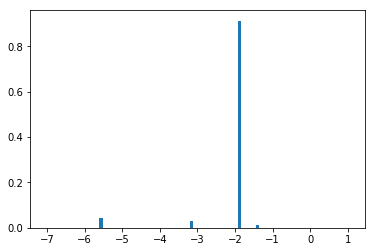

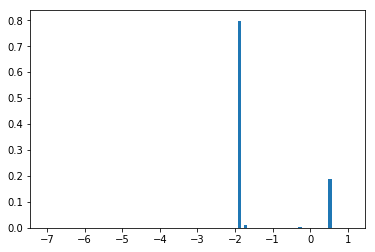

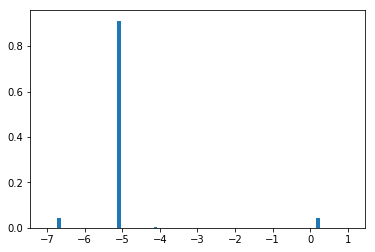

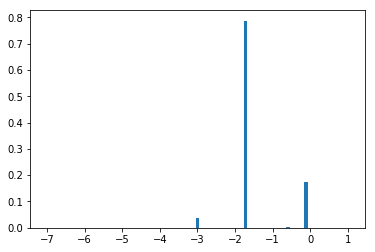

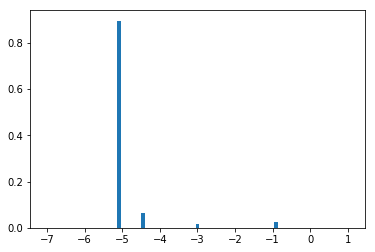

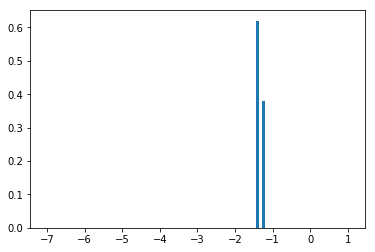

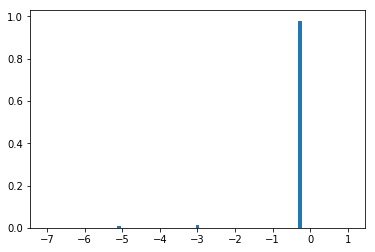

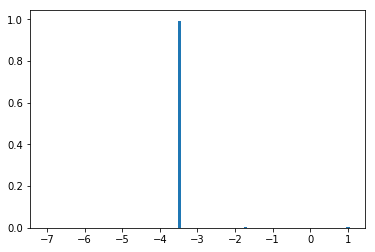

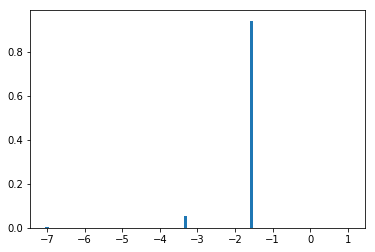

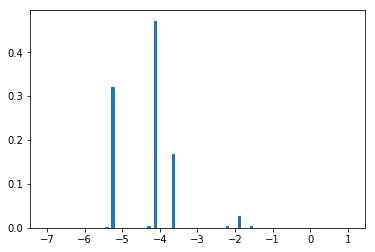

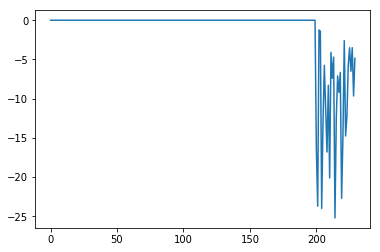

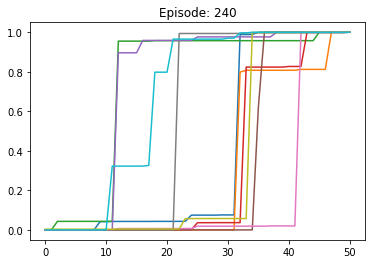

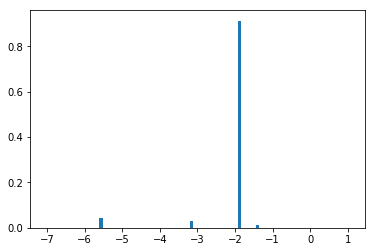

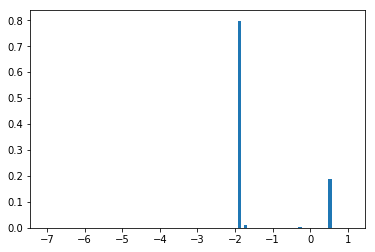

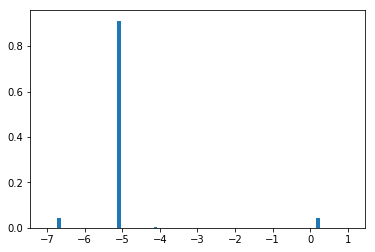

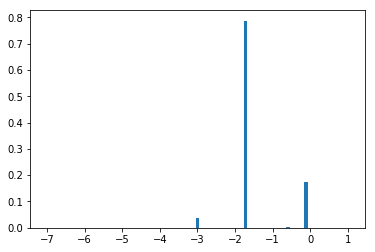

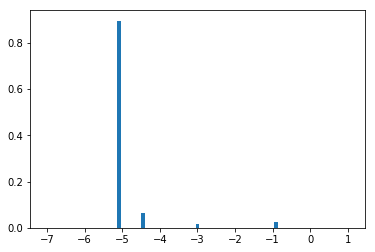

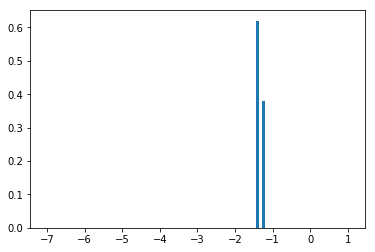

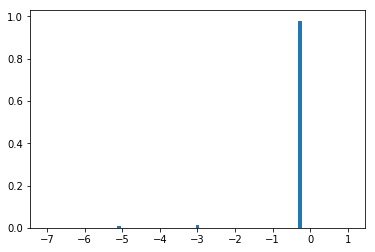

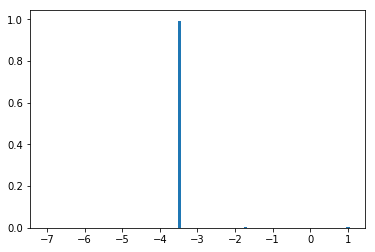

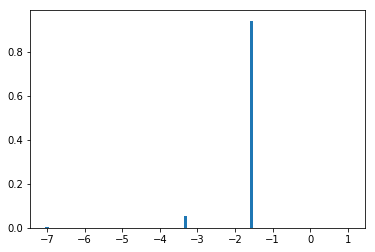

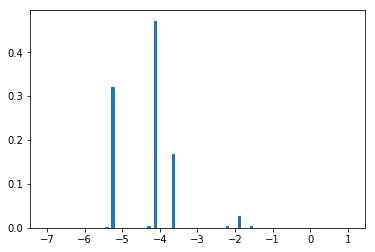

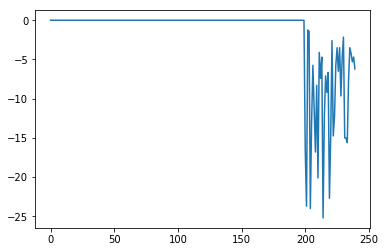

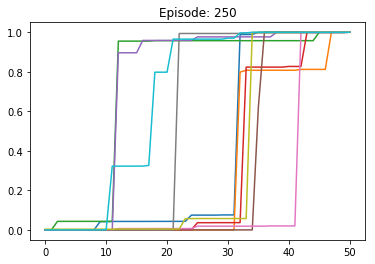

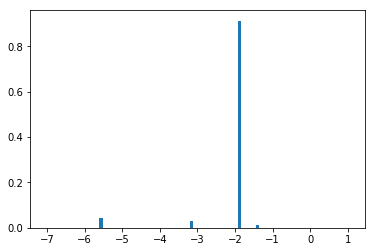

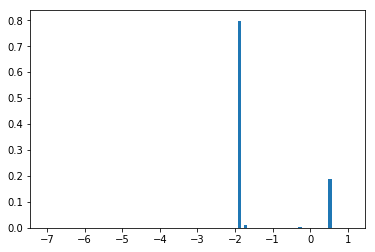

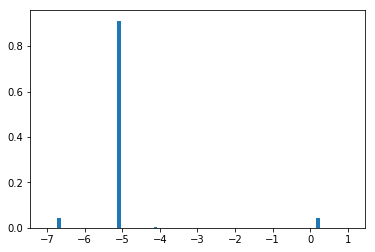

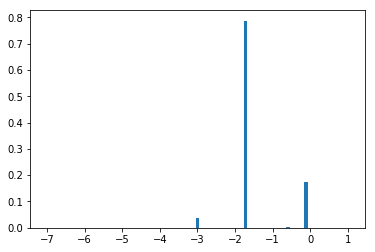

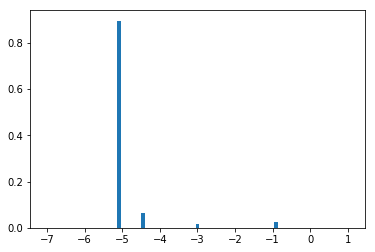

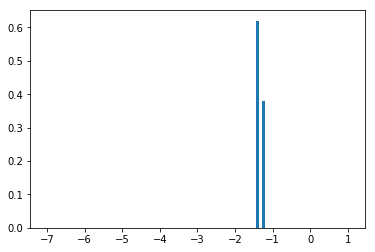

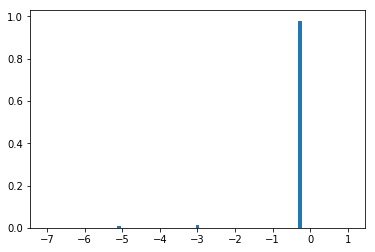

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [90]:
world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)
b_num = 10 # No bootstrap
config = Config(world.nS, world.nA)
config.Vmin = -7; config.Vmax = 1; config.nAtoms=51
c51 = []
for b in range(b_num):
    c51.append(C51Temp(config, init = 'temp', ifCVaR = True, temp=0.01))
#     plt.bar(c51[b].z, c51[b].p(12, 0)[:], width = 0.1)
#     plt.show()

num_episode = 500
max_step = 100
returns = np.zeros(num_episode)
# returns2[:200] = returns
#returns = returns2
CVaRs = np.zeros((num_episode, world.nA))
for ep in range(200, num_episode):
    terminal = False
    alpha = max(0.001, 0.005 + ep * ((0.001 - 0.005)/(num_episode/2)))
    o = world.reset()
    o_init = o
    ret = 0
    step = 0
    while not terminal and step < max_step:
        Qlist = np.array([x.CVaR(o, alpha=0.1, N=10) for x in c51])
        best = np.max(Qlist, axis = 0)
        a = np.argmax(best)
        network = np.argmax(Qlist[:, a])
        no, r, terminal = world.step(a) 
        ret += r
        c51[network].observe(o, a, r, no, terminal, alpha)
#         for jj in range(b_num):
#             if np.random.rand() <= 0.8:
#                 c51[jj].observe(o, a, r, no, terminal, alpha)
        o = no
        step += 1
    if ep%10 == 0:
        plt.figure()
        for i in range(b_num):
            plt.plot(np.cumsum(c51[i].p(12, 0)[:]), label = 'Bootstrap %d'%(i))
        #plt.plot(np.load('optimistic_cdf.npy'), label='true')
        plt.title('Episode: %d'%(ep))

        #plt.bar(c51[0].z-0.05, c51[0].p[12, 0, :], width=0.05, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
        #plt.plot(np.cumsum(c51[0].p[12, 0, :]))
        #plt.plot(np.cumsum(c51[1].p[12, 0, :])
        #plt.legend()
        plt.show()
        for b in range(b_num):
            c51.append(C51Temp(config, init = 'temp', ifCVaR = True, temp=1e-1))
            plt.bar(c51[b].z, c51[b].p(12, 0)[:], width = 0.1)
            plt.show()
        plt.figure()    
        plt.plot(returns[:ep])
        plt.show()
    returns[ep] = ret
    CVaRs[ep, :] = c51[0].CVaR(o_init, alpha=0.05, N=100)

In [ ]:
name = 'toy_gridworld_C51_N51_CVaR_alpha01_temp05_bootstrap_5'
np.save(name + '.npy', returns)
np.save(name + '_p.npy', c51[0].p)
np.save(name + '_z.npy', c51[0].z)
np.save(name + '_CVaRs.npy', CVaRs)

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(mv(returns, 50), label = '3 Bootstrap - temp = 0.05')

plt.title('10x10 toy grid world, returns, CVaR')
plt.plot(mv(np.load('toy_gridworld_C51_N51_CVaR_alpha01.npy'), 50), label = 'e-greedy, CVaR alpha =0.1')
plt.plot(mv(np.load('toy_gridworld_C51_N51_CVaR_alpha01_optimistic.npy'), 50), label = 'Optimisitic Init, CVaR alpha =0.1')
plt.plot(mv(np.load('toy_gridworld_C51_N51_CVaR_alpha01_optimistic_bootstrap_5.npy'), 50), label = 'Optimisitic Init, 5 Bootstrap, CVaR alpha =0.1')

plt.xlim([0, 450])
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid()


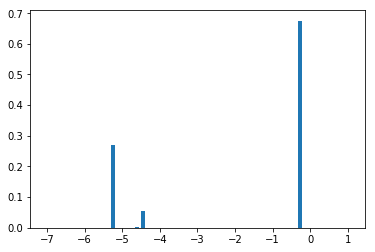

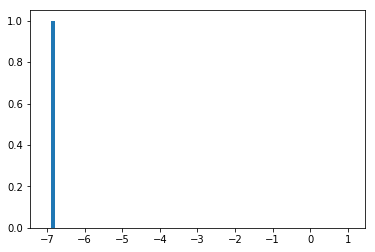

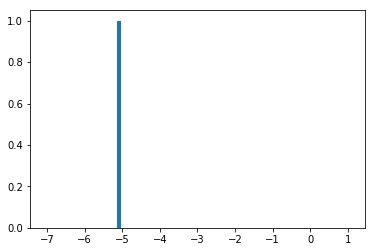

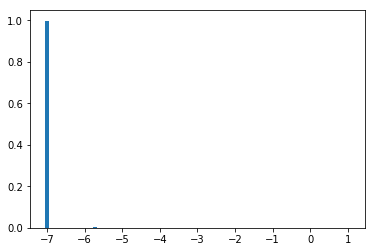

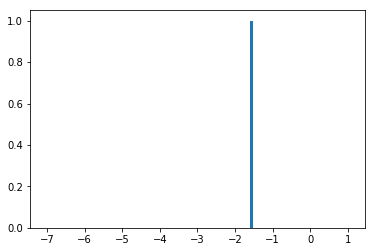

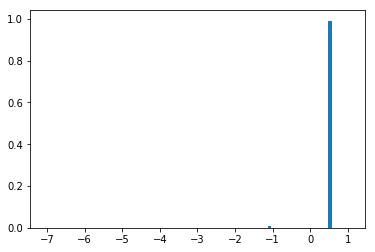

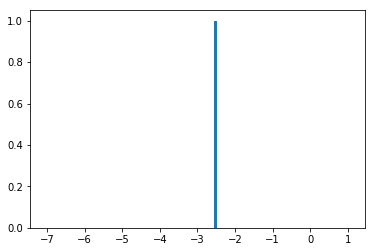

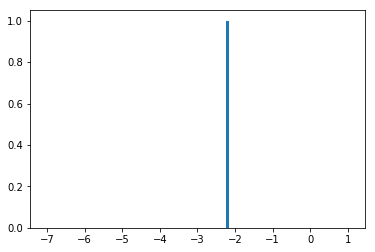

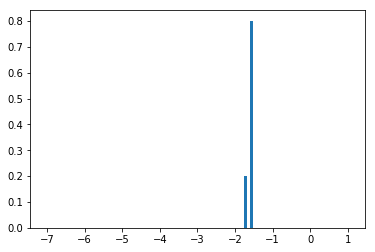

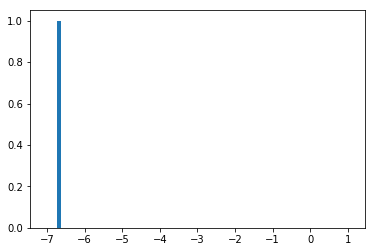

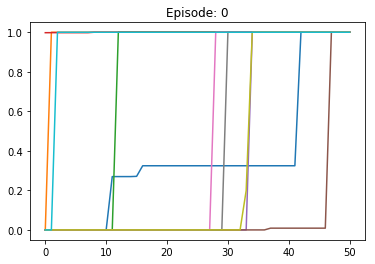

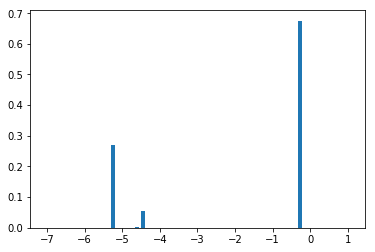

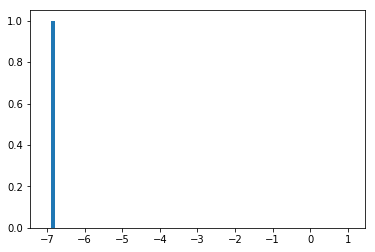

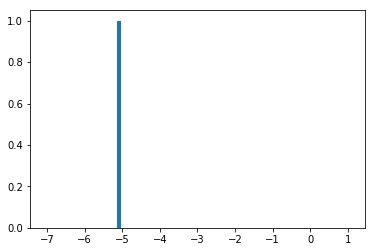

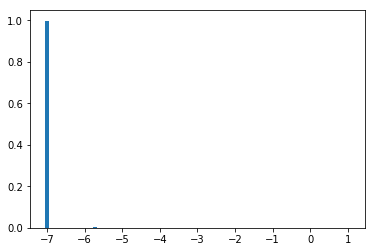

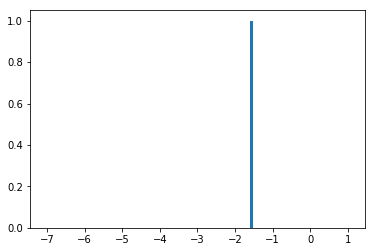

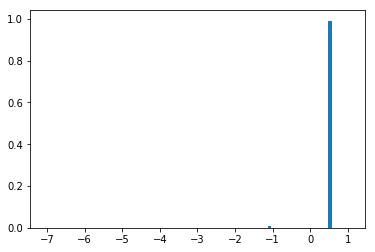

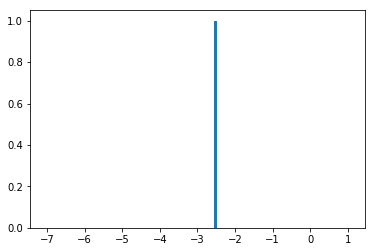

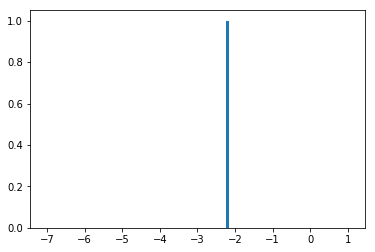

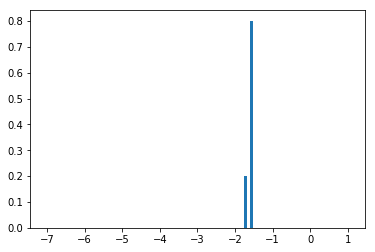

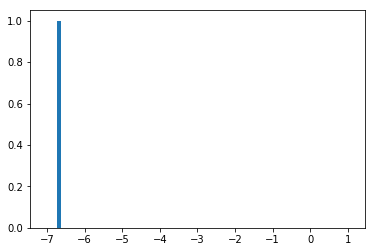

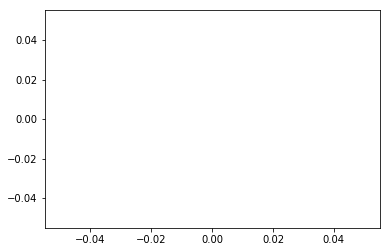

KeyboardInterrupt: 

In [102]:
 world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)
b_num = 10 # No bootstrap
config = Config(world.nS, world.nA)
config.Vmin = -7; config.Vmax = 1; config.nAtoms=51
c51 = []
for b in range(b_num):
    c51.append(C51Temp(config, init = 'temp', ifCVaR = True, temp=0.001))
    plt.bar(c51[b].z, c51[b].p(12, 0)[:], width = 0.1)
    plt.show()

num_episode = 500
max_step = 100
returns2 = np.zeros(num_episode)
#returns2[:200] = returns
#returns = returns2
CVaRs = np.zeros((num_episode, world.nA))
for ep in range(num_episode):
    terminal = False
    alpha = max(0.001, 0.005 + ep * ((0.001 - 0.005)/(num_episode/2)))
    o = world.reset()
    o_init = o
    ret = 0
    step = 0
    while not terminal and step < max_step:
        Qlist = np.array([x.CVaR(o, alpha=0.1, N=10) for x in c51])
        best = np.max(Qlist, axis = 0)
        a = np.argmax(best)
        network = np.argmax(Qlist[:, a])
        no, r, terminal = world.step(a) 
        ret += r
        c51[network].observe(o, a, r, no, terminal, alpha)
#         for jj in range(b_num):
#             if np.random.rand() <= 0.8:
#                 c51[jj].observe(o, a, r, no, terminal, alpha)
        o = no
        step += 1
    if ep%10 == 0:
        plt.figure()
        for i in range(b_num):
            plt.plot(np.cumsum(c51[i].p(12, 0)[:]), label = 'Bootstrap %d'%(i))
        #plt.plot(np.load('optimistic_cdf.npy'), label='true')
        plt.title('Episode: %d'%(ep))

        #plt.bar(c51[0].z-0.05, c51[0].p[12, 0, :], width=0.05, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
        #plt.plot(np.cumsum(c51[0].p[12, 0, :]))
        #plt.plot(np.cumsum(c51[1].p[12, 0, :])
        #plt.legend()
        plt.show()
        for b in range(b_num):
            c51.append(C51Temp(config, init = 'temp', ifCVaR = True, temp=1e-1))
            plt.bar(c51[b].z, c51[b].p(12, 0)[:], width = 0.1)
            plt.show()
        plt.figure()    
        plt.plot(returns[:ep])
        plt.show()
    returns[ep] = ret
    CVaRs[ep, :] = c51[0].CVaR(o_init, alpha=0.05, N=100)

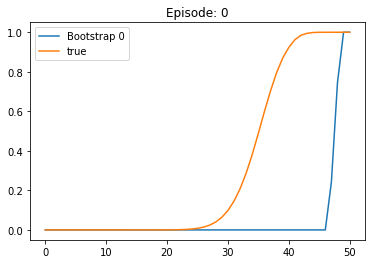

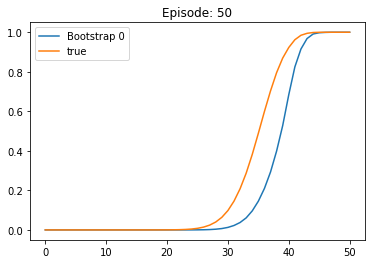

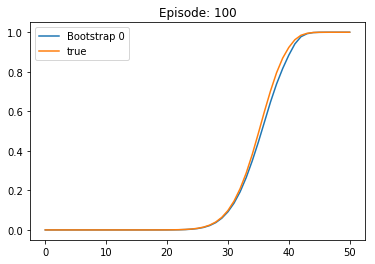

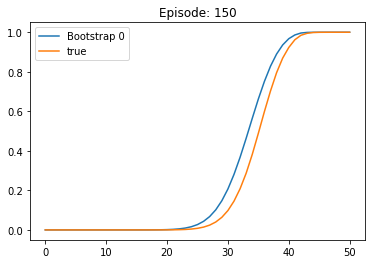

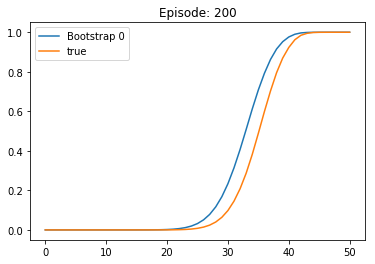

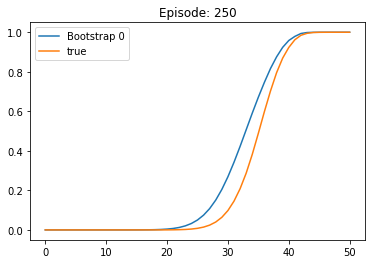

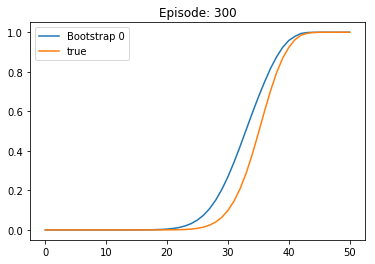

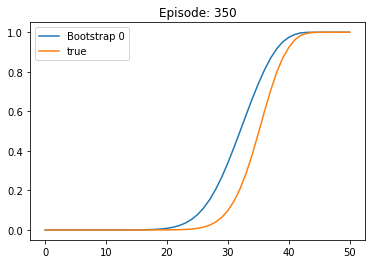

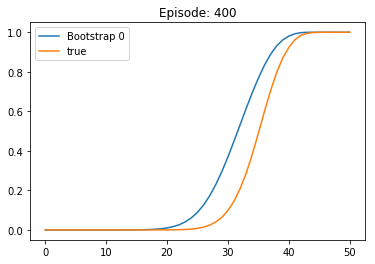

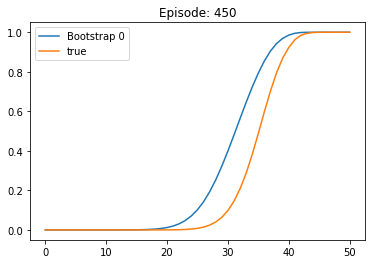

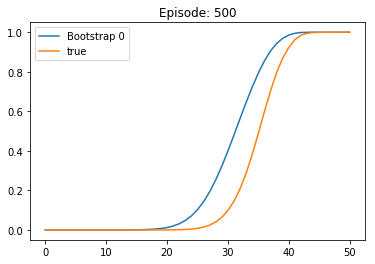

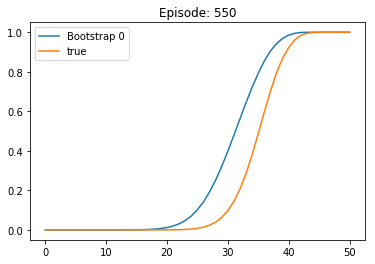

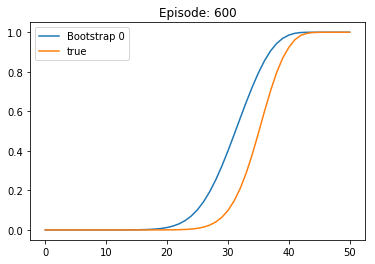

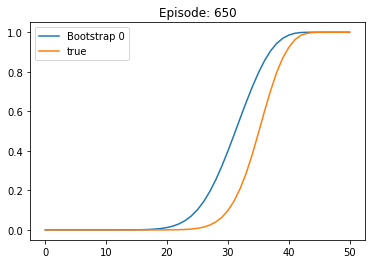

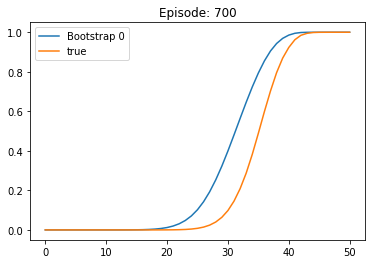

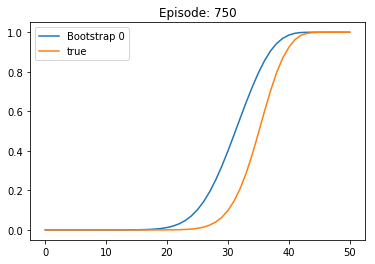

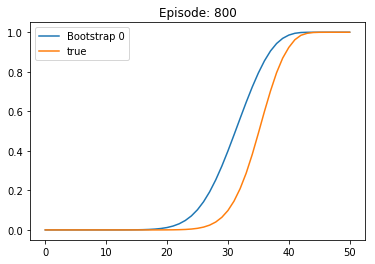

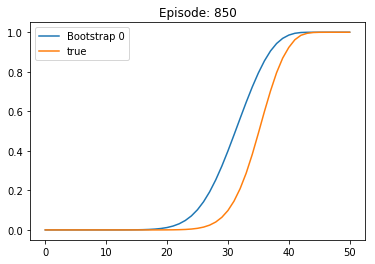

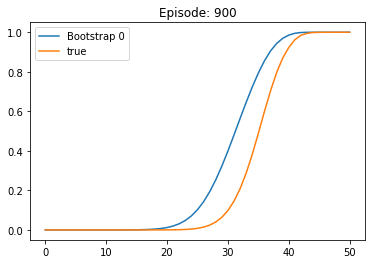

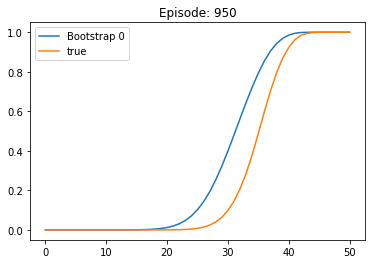

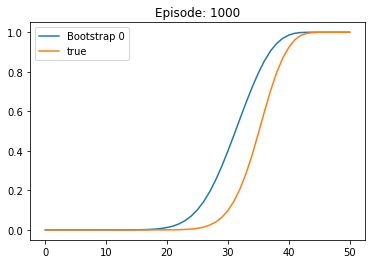

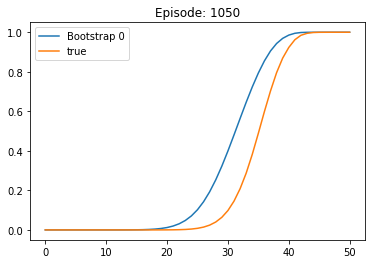

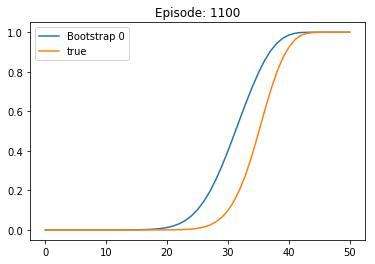

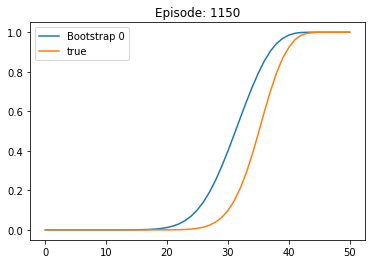

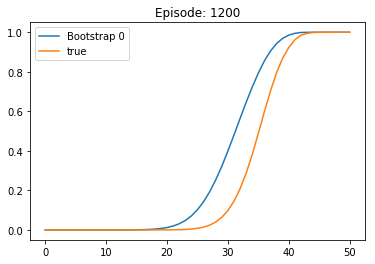

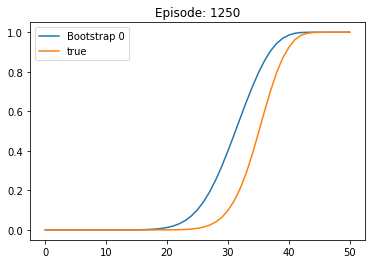

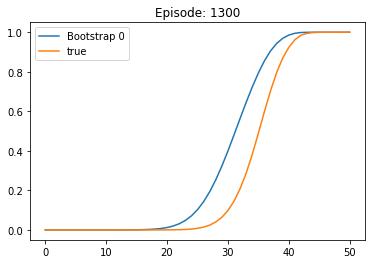

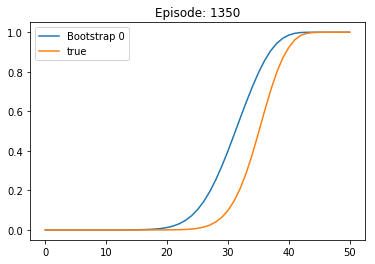

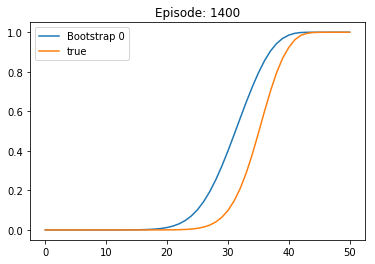

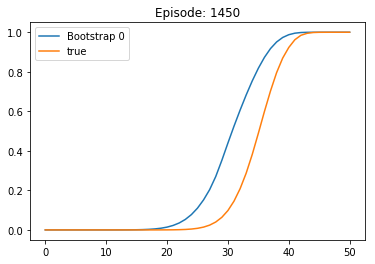

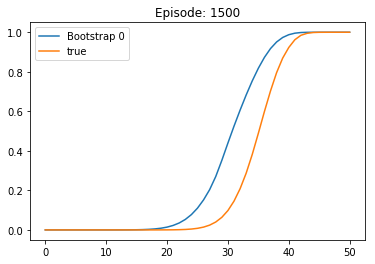

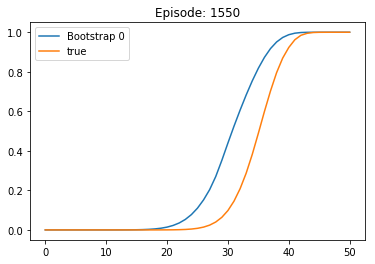

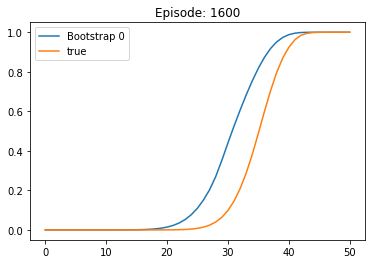

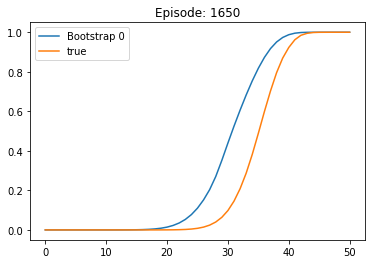

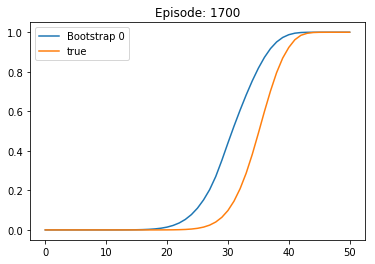

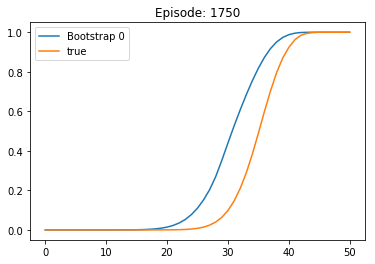

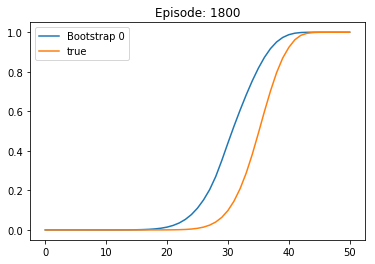

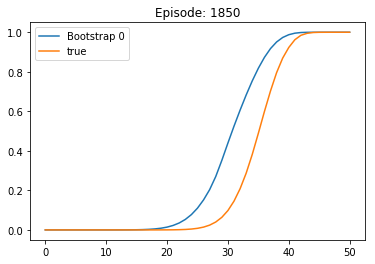

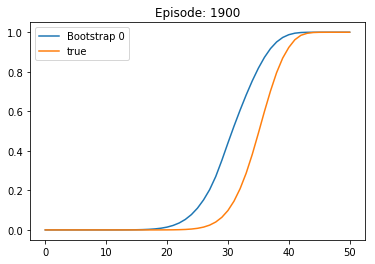

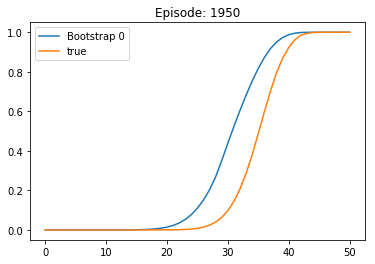

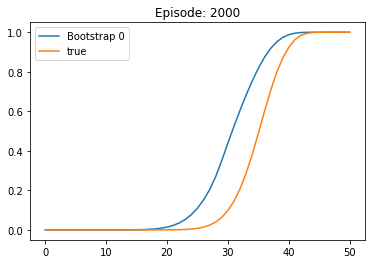

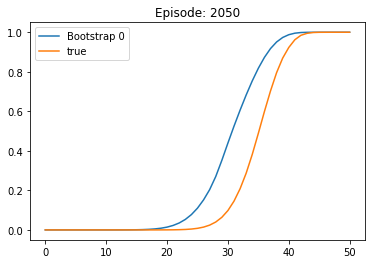

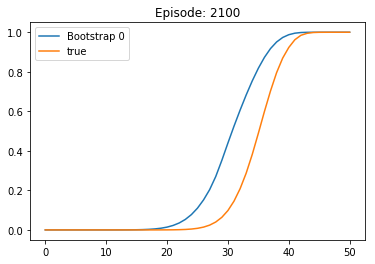

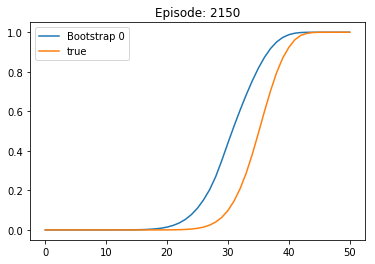

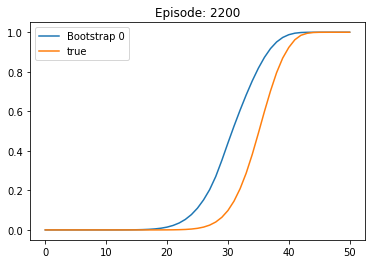

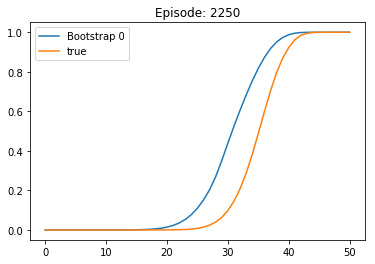

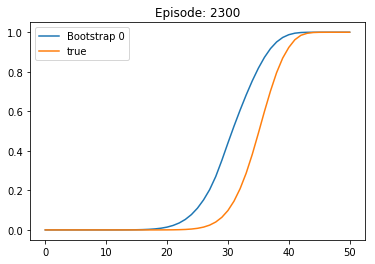

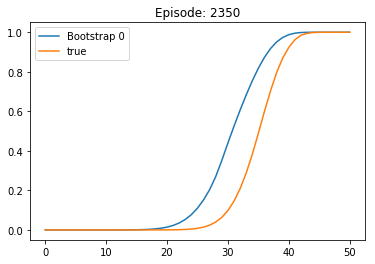

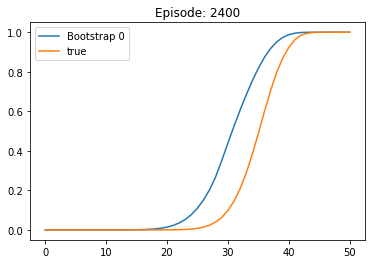

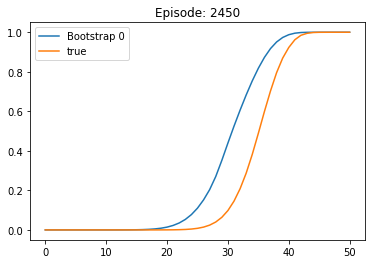

In [59]:
world = Gridworld(mapFile='map.txt', random=0, random_action_prob=0.3)
b_num = 1 # No bootstrap
config = Config(world.nS, world.nA)
config.Vmin = -7; config.Vmax = 1
c51 = []
for b in range(b_num):
    c51.append(C51(config, init = 'optimistic', ifCVaR = True))

num_episode = 2500
max_step = 300
returns = np.zeros(num_episode)
CVaRs = np.zeros((num_episode, world.nA))
for ep in range(num_episode):
    terminal = False
    #e = max(0.1, 0.9 + ep * ((0 - 0.9)/(num_episode/2)))
    alpha = max(0.001, 0.5 + ep * ((0.4 - 0.5)/(num_episode/2)))
    o = world.reset()
    o_init = o
    ret = 0
    step = 0
    while not terminal and step < max_step:
        Qlist = np.array([x.CVaR(o, alpha=0.1, N=50) for x in c51])
        best = np.max(Qlist, axis = 0)
        a = np.argmax(best)
        network = np.argmax(Qlist[:, a])
        no, r, terminal = world.step(a) 
        ret += r
        c51[network].observe(o, a, r, no, terminal, alpha)
        #for jj in range(b_num):
        #    if np.random.rand() <= 0.8:
        #        c51[jj].observe(o, a, r, no, terminal, alpha)
        o = no
        step += 1
    if ep%50 == 0:
        plt.figure()
        for i in range(b_num):
            plt.plot(np.cumsum(c51[i].p[12, 0, :]), label = 'Bootstrap %d'%(i))
        plt.plot(np.load('optimistic_cdf.npy'), label='true')
        plt.title('Episode: %d'%(ep))
        #plt.bar(c51[0].z-0.05, c51[0].p[12, 0, :], width=0.05, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
        #plt.plot(np.cumsum(c51[0].p[12, 0, :]))
        #plt.plot(np.cumsum(c51[1].p[12, 0, :])
        plt.legend()
        plt.show()
    returns[ep] = ret
    CVaRs[ep, :] = c51[0].CVaR(o_init, alpha=0.05, N=100)

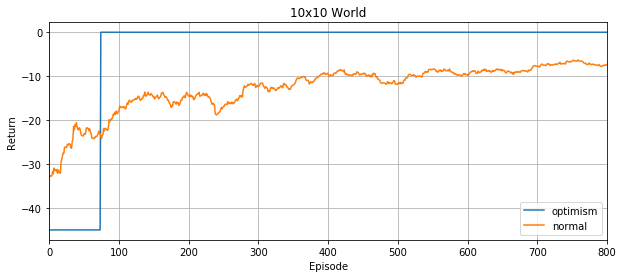

In [51]:
normal = np.load('C51returns_compare.npy')
plt.figure(figsize=(10, 4))
plt.title('10x10 World')
plt.plot(mv(returns, 1), label = 'optimism')
plt.plot(mv(normal, 40), label = 'normal')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid()
plt.xlim([0, 800]);

In [29]:
#np.save('optimistic_cdf.npy', np.cumsum(c51[0].p[12, 0, :]))

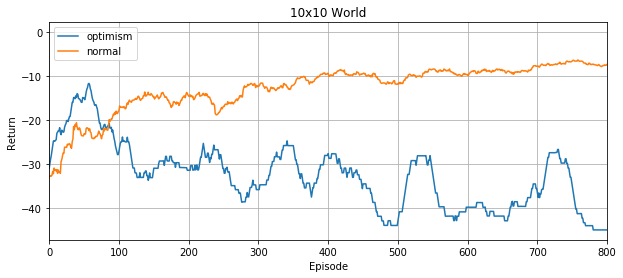

In [46]:
normal = np.load('C51returns_compare.npy')
plt.figure(figsize=(10, 4))
plt.title('10x10 World')
plt.plot(mv(returns, 40), label = 'optimism')
plt.plot(mv(normal, 40), label = 'normal')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid()
plt.xlim([0, 800]);

Text(0, 0.5, 'Prob')

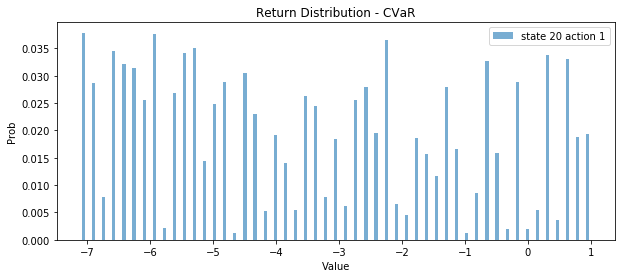

In [235]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution - CVaR')
#plt.bar(c51[0].z-0.05, c51[1].p[12, 0, :], width=0.05, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51[0].z-0.05, c51[0].p[12, 0, :], width=0.05, label = 'state 20 action 1', linewidth = 5, alpha=0.6)


plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

In [113]:
o = world.reset()
terminal=False
while not terminal:
    a = np.argmax(c51[1].CVaR(o, alpha=0.5, N=50))
    no, r, terminal = world.step(a) 
    o = no
    world._render()

##########
#0ssssssg#
#Xjjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# Xjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jXjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# sXssss #
#  ssss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  Xsss  #
#   ss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#  Xss   #
#        #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#  X     #
#        #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#  X     #
#        #
##########

##########
#0ssssssg#
# jjjjjj #
# ssssss #
#  ssss  #
#   ss   #
#        #
#   X    #
#        #
##########

#

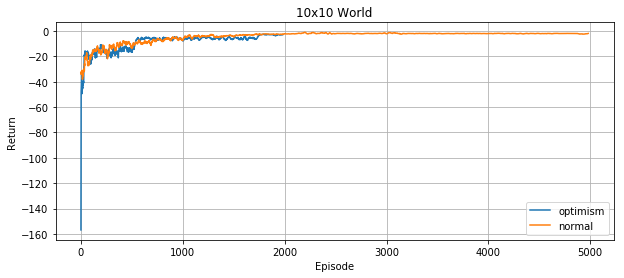

In [110]:
normal = np.load('C51returns_compare.npy')
plt.figure(figsize=(10, 4))
plt.title('10x10 World')
plt.plot(mv(returns, 20), label = 'optimism')
plt.plot(mv(normal, 20), label = 'normal')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid()
#plt.xlim([0, 2000]);

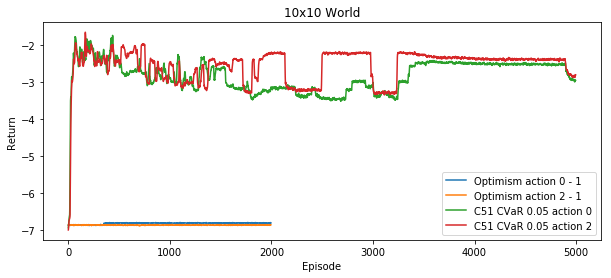

In [112]:
plt.figure(figsize=(10, 4))
plt.title('10x10 World')
plt.plot(mv(CVaRs1[:, 0], 5), label = 'Optimism action 0 - 1')
#plt.plot(mv(CVaRs2[:, 0], 5), label = 'Optimism action 0 - 2')
plt.plot(mv(CVaRs1[:, 2], 5), label = 'Optimism action 2 - 1')
#plt.plot(mv(CVaRs2[:, 2], 5), label = 'Optimism action 2 - 1')

normal = np.load('C51CVaRs.npy')
plt.plot(mv(normal[:, 0], 5), label = 'C51 CVaR 0.05 action 0')
plt.plot(mv(normal[:, 2], 5), label = 'C51 CVaR 0.05 action 2')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid()
#plt.ylim([-20, 0]);
#plt.xlim([0, 500])

plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid()
#plt.ylim([-20, 0]);
#plt.xlim([0, 500])

### Trash

In [610]:
### Running the same thing with CVaR action selection

In [620]:
### We need a new envinronemnt for CVaR, since the forzen lake is not okay! ###

In [6]:
from cliffwalker import *

In [81]:
env = GridWorld(5, 5, random_action_p=0.3)
config = Config(env.nS, env.nA)
config.Vmin = -30; config.Vmax = -2; config.gamma = 0.99; config.nAtoms=51
c51 = C51(config)
q = Qlearning(config)

num_episode = 2500
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.05, 1 + ep * ((0 - 9)/(num_episode)))
    alpha = max(0.001, 0.9 + ep * ((0 - 0.9)/(num_episode)))
    o = env.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(env.nA)
        else:
            a = np.argmax(c51.Q(o))
            #a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal = env.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        #q.observe(o, a, (r/100)+1, no, alpha)
        o = no
    returns[ep] = ret

In [149]:
np.save('cliffwalkerQlearning.npy', returns)

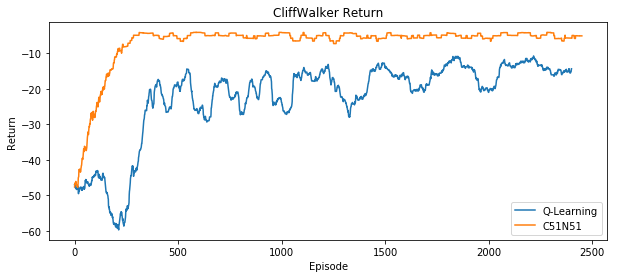

In [82]:
plt.figure(figsize=(10, 4))
plt.title('CliffWalker Return')
plt.plot(mv(np.load('cliffwalkerQlearning.npy'), 100), label = 'Q-Learning')
#plt.plot(mv(np.load('cliffwalkerC51N51q.npy'), 200), label = 'C51N51')
plt.plot(mv(returns, 50), label = 'C51N51')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return');

Text(0,0.5,'Prob')

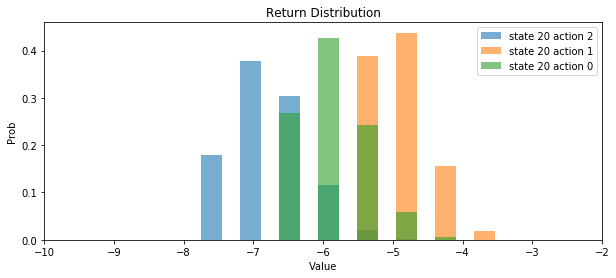

In [84]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[20, 2, :], width=0.3, label = 'state 20 action 2', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[20, 1, :], width=0.3, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[20, 0, :], width=0.3, label = 'state 20 action 0', linewidth = 5, alpha=0.6)
plt.legend()
plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

Text(0,0.5,'Prob')

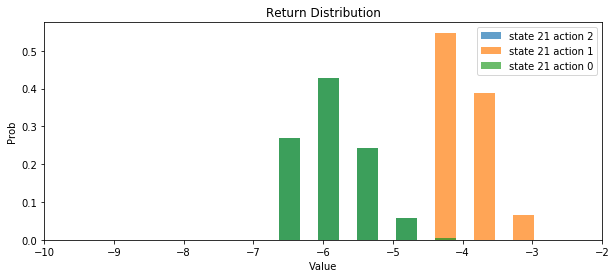

In [85]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[21, 2, :], width=0.3, label = 'state 21 action 2', linewidth = 5, alpha=0.7)
plt.bar(c51.z, c51.p[21, 1, :], width=0.3, label = 'state 21 action 1', linewidth = 5, alpha=0.7)
plt.bar(c51.z, c51.p[21, 0, :], width=0.3, label = 'state 21 action 0', linewidth = 5, alpha=0.7)
plt.legend()
plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

Text(0,0.5,'Prob')

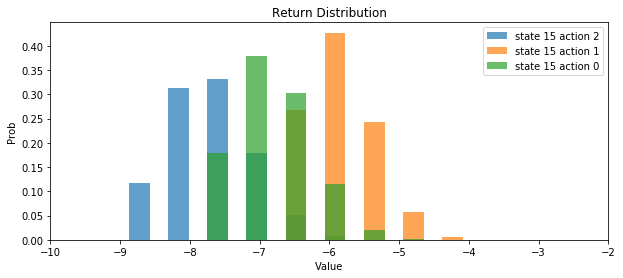

In [86]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[15, 2, :], width=0.3, label = 'state 15 action 2', linewidth = 5, alpha=0.7)
plt.bar(c51.z, c51.p[15, 1, :], width=0.3, label = 'state 15 action 1', linewidth = 5, alpha=0.7)
plt.bar(c51.z, c51.p[15, 0, :], width=0.3, label = 'state 15 action 0', linewidth = 5, alpha=0.7)
plt.legend()
plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

(30, 50)

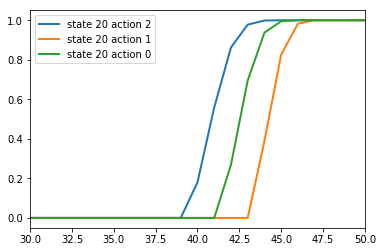

In [87]:
plt.plot(np.cumsum(c51.p[20, 2, :]), label = 'state 20 action 2', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 1, :]), label = 'state 20 action 1', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 0, :]), label = 'state 20 action 0', linewidth = 2)
plt.legend()
plt.xlim([30, 50])

In [88]:
### Running the same thing with CVaR action selection

In [13]:
env = GridWorld(10, 15, random_action_p=0.3)
config = Config(env.nS, env.nA)
config.Vmin = -30; config.Vmax = -2; config.gamma = 0.99; config.nAtoms=51
c51 = C51(config)
q = Qlearning(config)

num_episode = 5000
returns = np.zeros(num_episode)
for ep in range(num_episode):
    terminal = False
    e = max(0.05, 1 + ep * ((0 - 9)/(num_episode)))
    alpha = max(0.001, 0.9 + ep * ((0 - 0.9)/(num_episode)))
    o = env.reset()
    ret = 0
    while not terminal:
        if np.random.rand()<= e:
            a = np.random.randint(env.nA)
        else:
            a = np.argmax(c51.Q(o))
            #a = np.argmax(c51.CVaR(o, alpha=0.25, N=50))
            #a = np.argmax(q.Q[o, :])
        no, r, terminal = env.step(a) 
        ret += r
        c51.observe(o, a, r, no, terminal, alpha)
        #q.observe(o, a, (r/100)+1, no, alpha)
        o = no
    returns[ep] = ret

Text(0,0.5,'Prob')

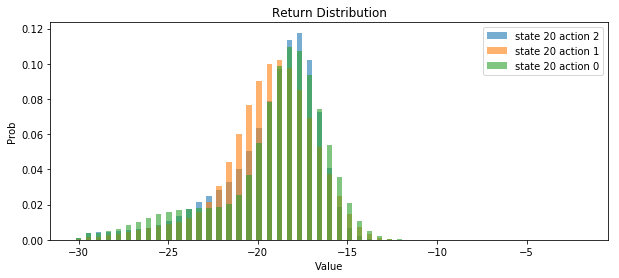

In [15]:
plt.figure(figsize=(10, 4))
plt.title('Return Distribution')
plt.bar(c51.z, c51.p[20, 2, :], width=0.3, label = 'state 20 action 2', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[20, 1, :], width=0.3, label = 'state 20 action 1', linewidth = 5, alpha=0.6)
plt.bar(c51.z, c51.p[20, 0, :], width=0.3, label = 'state 20 action 0', linewidth = 5, alpha=0.6)
plt.legend()
#plt.xlim([-10, -2])
plt.xlabel('Value')
plt.ylabel('Prob')

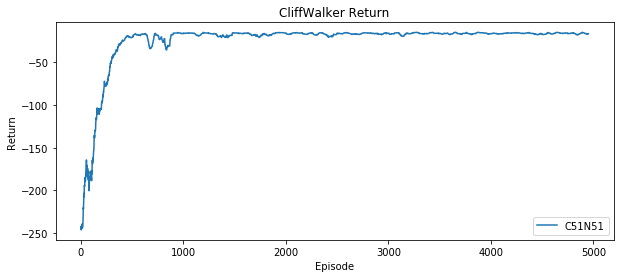

In [16]:
plt.figure(figsize=(10, 4))
plt.title('CliffWalker Return')
plt.plot(mv(returns, 50), label = 'C51N51')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Return');

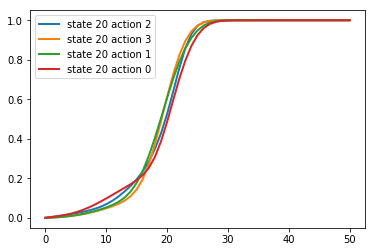

In [27]:
plt.plot(np.cumsum(c51.p[20, 2, :]), label = 'state 20 action 2', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 3, :]), label = 'state 20 action 3', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 1, :]), label = 'state 20 action 1', linewidth = 2)
plt.plot(np.cumsum(c51.p[20, 0, :]), label = 'state 20 action 0', linewidth = 2)
plt.xlim([])
plt.legend()

In [26]:
print(c51.CVaR(20, 0.1))

[-25.716 -25.352 -25.8   -24.4  ]
